In [1]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import sys
sys.path.append('./src/')
import common_utils,my_ensembler, feature_utils, defines, model_utils, my_bert, classes
import numpy as np
import imp
import pandas as pd
import seaborn as sns
from sklearn_crfsuite import CRF
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, RidgeClassifierCV, SGDClassifier
from sklearn.metrics import f1_score, recall_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from operator import itemgetter
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# import sklearn.grid_search

In [2]:
dir_name='duplicate'
final_pred_name='all_pred_fixed.threshold0.256'#merged.crf.bert.ens.c.w.l'
final_feature_name='local.plot.tfidf.30'
dataset_name='dataset_tf.word.char.lemma.full_splits'
cv_split_name='cv_splits_per_client'
seq_len=15
step=15
file_prefix='threshold'

In [3]:
all_pred_crf01=common_utils.load_db(dir_name,final_pred_name)

Opened /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/all_pred_fixed.threshold0.256.csv,  index False


In [4]:
all_pred_crf01

bert_group  bert_split  bert_predicted  bert_true  bert_proba_0  \
0               1           0               1          0       0.45525   
1               1           0               0          0       0.76593   
2               1           0               0          0       0.79398   
3               1           0               0          0       0.59757   
4               1           0               1          0       0.40709   
...           ...         ...             ...        ...           ...   
38429          79           7               0          0       0.70014   
38430          79           7               0          0       0.84534   
38431          79           7               0          0       0.85442   
38432          79           7               0          0       0.84201   
38433          79           7               0          0       0.86306   

       bert_proba_1  bert_sent_idx  bert_par  sent_idx  crf_group  ...  \
0           0.54475              0         0         0          1  ...   
1           0.23407              1         1         1          1  ...   
2           0.20602              2         2         2          1  ...   
3           0.40243              3         3         3          1  ...   
4           0.59291              4         4         4          1  ...   
...             ...            ...       ...       ...        ...  ...   
38429       0.29986           2983       171       254         79  ...   
38430       0.15466           2984       172       255         79  ...   
38431       0.14558           2985       172       256         79  ...   
38432       0.15799           2986       172       257         79  ...   
38433       0.13694           2987       172       258         79  ...   

       crf_proba_0  crf_proba_1  crf_sent_idx  ens_predicted  ens_proba_0  \
0            0.930        0.070             0              0      0.84699   
1            0.943        0.057             1              0      0.84595   
2            0.972        0.028             2              0      0.84583   
3            0.957        0.043             3              0      0.84611   
4            0.968        0.032             4              0      0.84717   
...            ...          ...           ...            ...          ...   
38429        0.872        0.128          2983              0      0.84198   
38430        0.994        0.006          2984              0      0.84326   
38431        0.999        0.001          2985              0      0.84387   
38432        1.000        0.000          2986              0      0.84348   
38433        0.999        0.001          2987              0      0.84420   

       ens_proba_1  ens_group  ens_split  ens_true  ens_par  
0          0.15301          1          0         0        0  
1          0.15405          1          0         0        1  
2          0.15417          1          0         0        2  
3          0.15389          1          0         0        3  
4          0.15283          1          0         0        4  
...            ...        ...        ...       ...      ...  
38429      0.15802         79          7         0      171  
38430      0.15674         79          7         0      172  
38431      0.15613         79          7         0      172  
38432      0.15652         79          7         0      172  
38433      0.15580         79          7         0      172  

[38434 rows x 24 columns]

In [19]:
error_db=pd.DataFrame()

In [14]:
model='bert'
bert_true_col='{}_true'.format(model)
bert_pred_col='{}_predicted'.format(model)
model='crf'
crf_true_col='{}_true'.format(model)
crf_pred_col='{}_predicted'.format(model)
all_pred_crf01[all_pred_crf01[true_col].eq(all_pred_crf01[pred_col])]

bert_group  bert_split  bert_predicted  bert_true  bert_proba_0  \
0               1           0               1          0       0.45525   
1               1           0               0          0       0.76593   
2               1           0               0          0       0.79398   
3               1           0               0          0       0.59757   
4               1           0               1          0       0.40709   
...           ...         ...             ...        ...           ...   
38429          79           7               0          0       0.70014   
38430          79           7               0          0       0.84534   
38431          79           7               0          0       0.85442   
38432          79           7               0          0       0.84201   
38433          79           7               0          0       0.86306   

       bert_proba_1  bert_sent_idx  bert_par  sent_idx  crf_group  ...  \
0           0.54475              0         0         0          1  ...   
1           0.23407              1         1         1          1  ...   
2           0.20602              2         2         2          1  ...   
3           0.40243              3         3         3          1  ...   
4           0.59291              4         4         4          1  ...   
...             ...            ...       ...       ...        ...  ...   
38429       0.29986           2983       171       254         79  ...   
38430       0.15466           2984       172       255         79  ...   
38431       0.14558           2985       172       256         79  ...   
38432       0.15799           2986       172       257         79  ...   
38433       0.13694           2987       172       258         79  ...   

       crf_proba_0  crf_proba_1  crf_sent_idx  ens_predicted  ens_proba_0  \
0            0.930        0.070             0              0      0.84699   
1            0.943        0.057             1              0      0.84595   
2            0.972        0.028             2              0      0.84583   
3            0.957        0.043             3              0      0.84611   
4            0.968        0.032             4              0      0.84717   
...            ...          ...           ...            ...          ...   
38429        0.872        0.128          2983              0      0.84198   
38430        0.994        0.006          2984              0      0.84326   
38431        0.999        0.001          2985              0      0.84387   
38432        1.000        0.000          2986              0      0.84348   
38433        0.999        0.001          2987              0      0.84420   

       ens_proba_1  ens_group  ens_split  ens_true  ens_par  
0          0.15301          1          0         0        0  
1          0.15405          1          0         0        1  
2          0.15417          1          0         0        2  
3          0.15389          1          0         0        3  
4          0.15283          1          0         0        4  
...            ...        ...        ...       ...      ...  
38429      0.15802         79          7         0      171  
38430      0.15674         79          7         0      172  
38431      0.15613         79          7         0      172  
38432      0.15652         79          7         0      172  
38433      0.15580         79          7         0      172  

[30334 rows x 24 columns]

In [20]:
error_db['doc']=all_pred_crf01['bert_group']
error_db['sent_idx']=all_pred_crf01['sent_idx']
error_db

doc  sent_idx
0        1         0
1        1         1
2        1         2
3        1         3
4        1         4
...    ...       ...
38429   79       254
38430   79       255
38431   79       256
38432   79       257
38433   79       258

[38434 rows x 2 columns]

In [21]:
error_db=error_db.assign(bert_correct=all_pred_crf01[bert_true_col].eq(all_pred_crf01[bert_pred_col]))

In [22]:
error_db=error_db.assign(crf_correct=all_pred_crf01[crf_true_col].eq(all_pred_crf01[crf_pred_col]))

In [23]:
error_db

doc  sent_idx  bert_correct  crf_correct
0        1         0         False         True
1        1         1          True         True
2        1         2          True         True
3        1         3          True         True
4        1         4         False         True
...    ...       ...           ...          ...
38429   79       254          True         True
38430   79       255          True         True
38431   79       256          True         True
38432   79       257          True         True
38433   79       258          True         True

[38434 rows x 4 columns]

In [24]:
error_db=error_db.assign(uniq_bert=(error_db['bert_correct']==False)&(error_db['crf_correct']==True))

In [25]:
error_db

doc  sent_idx  bert_correct  crf_correct  uniq_bert
0        1         0         False         True       True
1        1         1          True         True      False
2        1         2          True         True      False
3        1         3          True         True      False
4        1         4         False         True       True
...    ...       ...           ...          ...        ...
38429   79       254          True         True      False
38430   79       255          True         True      False
38431   79       256          True         True      False
38432   79       257          True         True      False
38433   79       258          True         True      False

[38434 rows x 5 columns]

In [26]:
error_db=error_db.assign(uniq_crf=(error_db['crf_correct']==False)&(error_db['bert_correct']==True))

In [45]:
error_db

doc  sent_idx  bert_correct  crf_correct  uniq_bert  uniq_crf owner
0        1         0         False         True       True     False   NaN
1        1         1          True         True      False     False   NaN
2        1         2          True         True      False     False   NaN
3        1         3          True         True      False     False   NaN
4        1         4         False         True       True     False   NaN
...    ...       ...           ...          ...        ...       ...   ...
38429   79       254          True         True      False     False   NaN
38430   79       255          True         True      False     False   NaN
38431   79       256          True         True      False     False   NaN
38432   79       257          True         True      False     False   NaN
38433   79       258          True         True      False     False   NaN

[38434 rows x 7 columns]

In [51]:
def get_who_unique(bert,crf):
    if bert==True and crf==False:
        return 'BERT'
    if bert==False and crf==True:
        return 'CRF'


def get_sublist(sta,end):
    return mylist[sta:end+1]

# df['col_3'] = df.apply(lambda x: get_sublist(x.col_1, x.col_2), axis=1)

In [52]:
error_db['owner']=error_db.apply(lambda x: get_who_unique(x.uniq_bert,x.uniq_crf),axis=1)

In [59]:
error_db['is_nar']=all_pred_crf01['bert_true']

In [60]:
common_utils.save_db(error_db,dir_name,'uniq_errors_db')

Saving /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/uniq_errors_db.csv, 
index False
float_format %.5f


In [86]:
error_db

doc  sent_idx  bert_correct  crf_correct  uniq_bert  uniq_crf owner  \
0        1         0         False         True       True     False  BERT   
1        1         1          True         True      False     False  None   
2        1         2          True         True      False     False  None   
3        1         3          True         True      False     False  None   
4        1         4         False         True       True     False  BERT   
...    ...       ...           ...          ...        ...       ...   ...   
38429   79       254          True         True      False     False  None   
38430   79       255          True         True      False     False  None   
38431   79       256          True         True      False     False  None   
38432   79       257          True         True      False     False  None   
38433   79       258          True         True      False     False  None   

       is_nar  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
38429       0  
38430       0  
38431       0  
38432       0  
38433       0  

[38434 rows x 8 columns]

In [87]:
sent_label_db = common_utils.concat_dbs(dir_name,"sent_db")

In [88]:
sent_label_db

file_idx  sent_idx  is_question  \
0             1         0          0.0   
1             1         1          0.0   
2             1         2          1.0   
3             1         3          0.0   
4             1         4          0.0   
...         ...       ...          ...   
38429        80       525          0.0   
38430        80       526          0.0   
38431        80       527          0.0   
38432        80       528          1.0   
38433        80       529          0.0   

                                                    text  sent_idx_in_block  \
0      אז היום אנחנו נפגשים פה ב 123  אבל שבוע הבא בח...                0.0   
1                                                     כן                0.0   
2                                        אוקיי  מה שלומך                0.0   
3                                               ברוך השם                0.0   
4                                    מחר יש לכם יום טיול                0.0   
...                                                  ...                ...   
38429                              שאני מרגיש בהם לא נוח                3.0   
38430                        אז כאילו למה למה אני מתגעגע                4.0   
38431                            או למה אני למה אני רוצה                5.0   
38432                                 והצלחת לענות לעצמך                0.0   
38433                                    היה לי מאוד קשה                0.0   

       block_idx  is_nar  doc_idx  par_db_idx  par_idx_in_doc  par_pos_in_doc  \
0            0.0     0.0      1.0         0.0             0.0        0.004878   
1            1.0     0.0      1.0         1.0             1.0        0.009756   
2            2.0     0.0      1.0         2.0             2.0        0.014634   
3            3.0     0.0      1.0         3.0             3.0        0.019512   
4            4.0     0.0      1.0         4.0             4.0        0.024390   
...          ...     ...      ...         ...             ...             ...   
38429      230.0     0.0     80.0       222.0           222.0        0.991111   
38430      230.0     0.0     80.0       222.0           222.0        0.991111   
38431      230.0     0.0     80.0       222.0           222.0        0.991111   
38432      231.0     0.0     80.0       223.0           223.0        0.995556   
38433      232.0     0.0     80.0       224.0           224.0        1.000000   

        par_type block_type  nar_idx  sent_len  is_client  sent_idx_in_par  \
0      therapist    not_nar      0.0      50.0          0                0   
1         client    not_nar      0.0       2.0          1                0   
2      therapist    not_nar      0.0      16.0          0                0   
3         client    not_nar      0.0       8.0          1                0   
4      therapist    not_nar      0.0      19.0          0                0   
...          ...        ...      ...       ...        ...              ...   
38429     client    not_nar      0.0      21.0          1                3   
38430     client    not_nar      0.0      27.0          1                4   
38431     client    not_nar      0.0      23.0          1                5   
38432  therapist    not_nar      0.0      19.0          0                0   
38433     client    not_nar      0.0      15.0          1                0   

       sent_pos_in_par  sent_pos_in_doc  
0             1.000000         0.001631  
1             1.000000         0.003263  
2             1.000000         0.004894  
3             1.000000         0.006525  
4             1.000000         0.008157  
...                ...              ...  
38429         0.666667         0.992453  
38430         0.833333         0.994340  
38431         1.000000         0.996226  
38432         1.000000         0.998113  
38433         1.000000         1.000000  

[38434 rows x 19 columns]

In [89]:
sent_pos_count_db =  common_utils.concat_dbs(dir_name,"sent_pos_count_db")

In [90]:
sent_pos_count_db

doc_idx  sent_idx  TOKEN  POSTAG_ADVERB  POSTAG_AT  POSTAG_BN  \
0            1         0      7            0.0        0.0   0.142857   
1            1         1      1            0.0        0.0   0.000000   
2            1         2      2            0.0        0.0   0.000000   
3            1         3      2            0.0        0.0   0.000000   
4            1         4      5            0.0        0.0   0.000000   
...        ...       ...    ...            ...        ...        ...   
38429       80       525      5            0.0        0.0   0.200000   
38430       80       526      6            0.0        0.0   0.166667   
38431       80       527      6            0.0        0.0   0.166667   
38432       80       528      3            0.0        0.0   0.000000   
38433       80       529      4            0.0        0.0   0.000000   

       POSTAG_BNT  POSTAG_CC  POSTAG_CD  POSTAG_CDT  ...   f_per_2  f_per_3  \
0             0.0   0.142857   0.285714         0.0  ...  0.000000     0.00   
1             0.0   0.000000   0.000000         0.0  ...  0.000000     0.00   
2             0.0   0.000000   0.000000         0.0  ...  0.000000     0.00   
3             0.0   0.000000   0.000000         0.0  ...  0.000000     0.00   
4             0.0   0.000000   0.000000         0.0  ...  0.200000     0.00   
...           ...        ...        ...         ...  ...       ...      ...   
38429         0.0   0.000000   0.000000         0.0  ...  0.000000     0.20   
38430         0.0   0.166667   0.000000         0.0  ...  0.000000     0.00   
38431         0.0   0.166667   0.000000         0.0  ...  0.000000     0.00   
38432         0.0   0.000000   0.000000         0.0  ...  0.333333     0.00   
38433         0.0   0.000000   0.000000         0.0  ...  0.000000     0.25   

        f_per_A  f_tense_BEINONI  f_tense_FUTURE  f_tense_IMPERATIVE  \
0      0.142857              0.0             0.0                 0.0   
1      0.000000              0.0             0.0                 0.0   
2      0.000000              0.0             0.0                 0.0   
3      0.000000              0.0             0.0                 0.0   
4      0.000000              0.0             0.0                 0.0   
...         ...              ...             ...                 ...   
38429  0.200000              0.0             0.0                 0.0   
38430  0.166667              0.0             0.0                 0.0   
38431  0.166667              0.0             0.0                 0.0   
38432  0.000000              0.0             0.0                 0.0   
38433  0.000000              0.0             0.0                 0.0   

       f_tense_PAST  POSTAG_NEG  POSTAG_yyCM  POSTAG_TTL  
0               0.0         NaN          NaN         NaN  
1               0.0         NaN          NaN         NaN  
2               0.0         NaN          NaN         NaN  
3               0.0         NaN          NaN         NaN  
4               0.0         NaN          NaN         NaN  
...             ...         ...          ...         ...  
38429           0.0         NaN          NaN         NaN  
38430           0.0         NaN          NaN         NaN  
38431           0.0         NaN          NaN         NaN  
38432           0.0         NaN          NaN         NaN  
38433           0.0         NaN          NaN         NaN  

[38434 rows x 57 columns]

In [91]:
merged_error_db=error_db.merge(sent_label_db,left_on=['doc','sent_idx'],right_on=['file_idx','sent_idx'],validate='one_to_one')

In [92]:
merged_error_db

doc  sent_idx  bert_correct  crf_correct  uniq_bert  uniq_crf owner  \
0        1         0         False         True       True     False  BERT   
1        1         1          True         True      False     False  None   
2        1         2          True         True      False     False  None   
3        1         3          True         True      False     False  None   
4        1         4         False         True       True     False  BERT   
...    ...       ...           ...          ...        ...       ...   ...   
38429   79       254          True         True      False     False  None   
38430   79       255          True         True      False     False  None   
38431   79       256          True         True      False     False  None   
38432   79       257          True         True      False     False  None   
38433   79       258          True         True      False     False  None   

       is_nar_x  file_idx  is_question  ... par_idx_in_doc  par_pos_in_doc  \
0             0         1          0.0  ...            0.0        0.004878   
1             0         1          0.0  ...            1.0        0.009756   
2             0         1          1.0  ...            2.0        0.014634   
3             0         1          0.0  ...            3.0        0.019512   
4             0         1          0.0  ...            4.0        0.024390   
...         ...       ...          ...  ...            ...             ...   
38429         0        79          0.0  ...          171.0        0.994220   
38430         0        79          0.0  ...          172.0        1.000000   
38431         0        79          0.0  ...          172.0        1.000000   
38432         0        79          0.0  ...          172.0        1.000000   
38433         0        79          0.0  ...          172.0        1.000000   

        par_type  block_type  nar_idx  sent_len  is_client  sent_idx_in_par  \
0      therapist     not_nar      0.0      50.0          0                0   
1         client     not_nar      0.0       2.0          1                0   
2      therapist     not_nar      0.0      16.0          0                0   
3         client     not_nar      0.0       8.0          1                0   
4      therapist     not_nar      0.0      19.0          0                0   
...          ...         ...      ...       ...        ...              ...   
38429     client     not_nar      0.0       3.0          1                0   
38430  therapist     not_nar      0.0      78.0          0                0   
38431  therapist     not_nar      0.0      95.0          0                1   
38432  therapist     not_nar      0.0     137.0          0                2   
38433  therapist     not_nar      0.0     103.0          0                3   

      sent_pos_in_par sent_pos_in_doc  
0                1.00        0.001631  
1                1.00        0.003263  
2                1.00        0.004894  
3                1.00        0.006525  
4                1.00        0.008157  
...               ...             ...  
38429            1.00        0.984556  
38430            0.25        0.988417  
38431            0.50        0.992278  
38432            0.75        0.996139  
38433            1.00        1.000000  

[38434 rows x 26 columns]

In [93]:
merged_error_db=merged_error_db.merge(sent_pos_count_db,left_on=['doc','sent_idx'],right_on=['doc_idx','sent_idx'],validate='one_to_one')

In [94]:
merged_error_db

doc  sent_idx  bert_correct  crf_correct  uniq_bert  uniq_crf owner  \
0        1         0         False         True       True     False  BERT   
1        1         1          True         True      False     False  None   
2        1         2          True         True      False     False  None   
3        1         3          True         True      False     False  None   
4        1         4         False         True       True     False  BERT   
...    ...       ...           ...          ...        ...       ...   ...   
38429   79       254          True         True      False     False  None   
38430   79       255          True         True      False     False  None   
38431   79       256          True         True      False     False  None   
38432   79       257          True         True      False     False  None   
38433   79       258          True         True      False     False  None   

       is_nar_x  file_idx  is_question  ...   f_per_2   f_per_3   f_per_A  \
0             0         1          0.0  ...  0.000000  0.000000  0.142857   
1             0         1          0.0  ...  0.000000  0.000000  0.000000   
2             0         1          1.0  ...  0.000000  0.000000  0.000000   
3             0         1          0.0  ...  0.000000  0.000000  0.000000   
4             0         1          0.0  ...  0.200000  0.000000  0.000000   
...         ...       ...          ...  ...       ...       ...       ...   
38429         0        79          0.0  ...  0.000000  0.000000  0.000000   
38430         0        79          0.0  ...  0.117647  0.058824  0.117647   
38431         0        79          0.0  ...  0.066667  0.200000  0.000000   
38432         0        79          0.0  ...  0.052632  0.368421  0.157895   
38433         0        79          0.0  ...  0.090909  0.181818  0.000000   

       f_tense_BEINONI  f_tense_FUTURE  f_tense_IMPERATIVE  f_tense_PAST  \
0             0.000000        0.000000                 0.0      0.000000   
1             0.000000        0.000000                 0.0      0.000000   
2             0.000000        0.000000                 0.0      0.000000   
3             0.000000        0.000000                 0.0      0.000000   
4             0.000000        0.000000                 0.0      0.000000   
...                ...             ...                 ...           ...   
38429         0.000000        0.000000                 0.0      0.000000   
38430         0.000000        0.000000                 0.0      0.000000   
38431         0.066667        0.000000                 0.0      0.000000   
38432         0.000000        0.210526                 0.0      0.105263   
38433         0.000000        0.136364                 0.0      0.045455   

       POSTAG_NEG POSTAG_yyCM POSTAG_TTL  
0             NaN         NaN        NaN  
1             NaN         NaN        NaN  
2             NaN         NaN        NaN  
3             NaN         NaN        NaN  
4             NaN         NaN        NaN  
...           ...         ...        ...  
38429         NaN         NaN        NaN  
38430         NaN         NaN        NaN  
38431         NaN         NaN        NaN  
38432         NaN         NaN        NaN  
38433         NaN         NaN        NaN  

[38434 rows x 82 columns]

In [95]:
uniq_err=merged_error_db[~merged_error_db['owner'].isna()].copy()

In [96]:
uniq_err.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9658 entries, 0 to 38421
Data columns (total 82 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   doc                 9658 non-null   int64  
 1   sent_idx            9658 non-null   int64  
 2   bert_correct        9658 non-null   bool   
 3   crf_correct         9658 non-null   bool   
 4   uniq_bert           9658 non-null   bool   
 5   uniq_crf            9658 non-null   bool   
 6   owner               9658 non-null   object 
 7   is_nar_x            9658 non-null   int64  
 8   file_idx            9658 non-null   int64  
 9   is_question         9658 non-null   float64
 10  text                9658 non-null   object 
 11  sent_idx_in_block   9658 non-null   float64
 12  block_idx           9658 non-null   float64
 13  is_nar_y            9658 non-null   float64
 14  doc_idx_x           9658 non-null   float64
 15  par_db_idx          9658 non-null   float64
 16  par_i

In [140]:
uniq_err.groupby('owner')['sent_len'].describe()

count       mean        std  min   25%   50%   75%     max
owner                                                             
BERT   5743.0  50.437576  60.952505  1.0  20.0  34.0  60.0  1226.0
CRF    3915.0  63.692720  86.746053  1.0  21.0  39.0  73.0  1229.0

In [224]:
uniq_err.groupby('owner')['sent_len'].median()

owner
BERT    34.0
CRF     39.0
Name: sent_len, dtype: float64

In [223]:
uniq_err.groupby('owner')['TOKEN'].describe()

count       mean        std  min  25%  50%   75%    max
owner                                                          
BERT   5743.0   9.193279   8.338780  1.0  4.0  7.0  11.0   89.0
CRF    3915.0  11.096807  11.440972  1.0  4.0  8.0  14.0  166.0

In [225]:
uniq_err.groupby('owner')['TOKEN'].median()

owner
BERT    7.0
CRF     8.0
Name: TOKEN, dtype: float64

In [111]:
uniq_err['POSTAG_TTL'].value_counts()

0.0    53
Name: POSTAG_TTL, dtype: int64

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


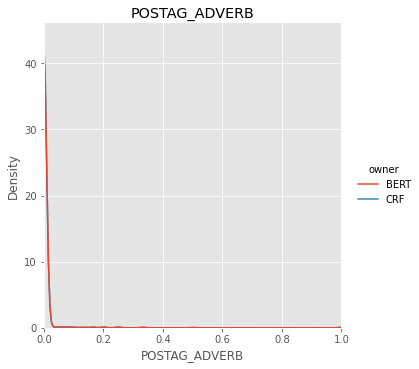

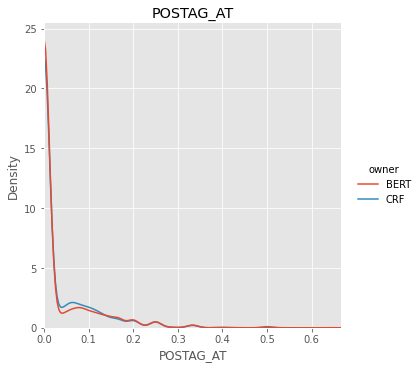

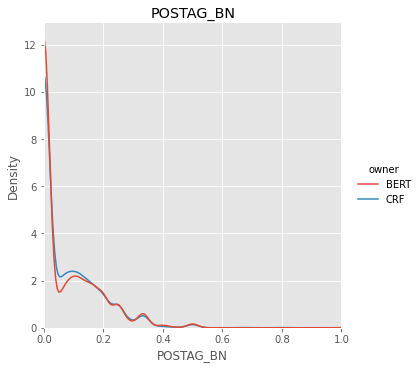

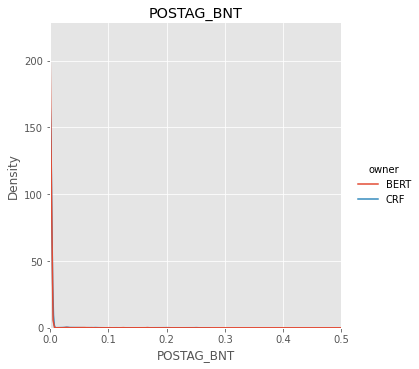

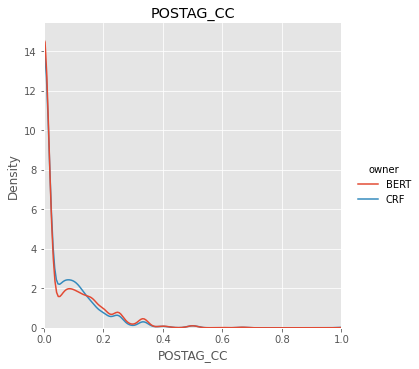

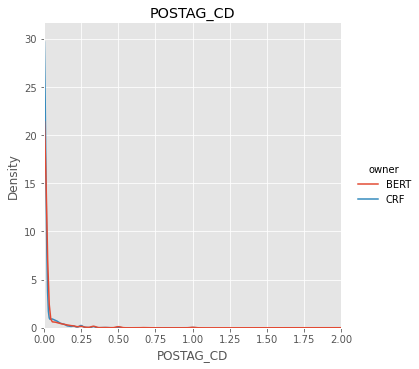

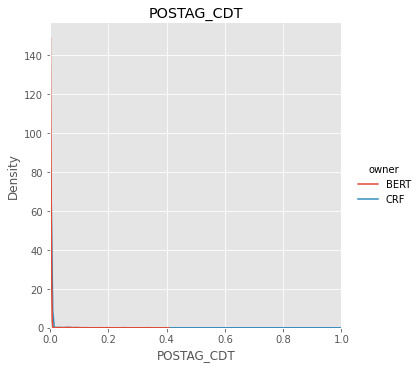

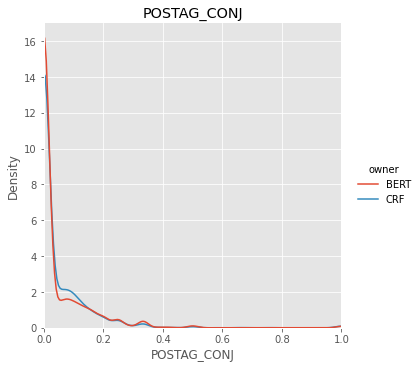

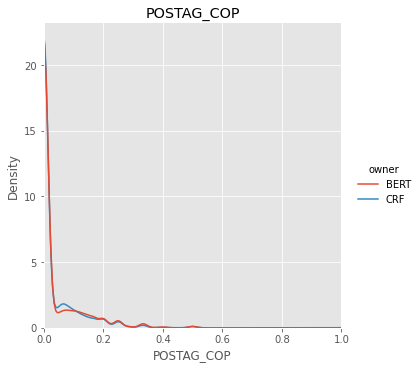

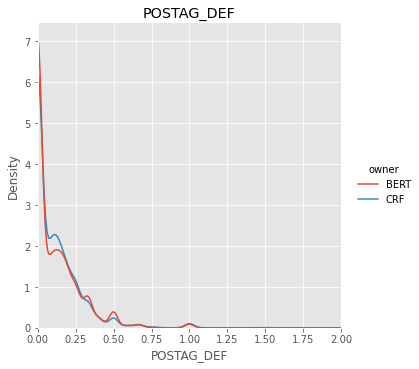

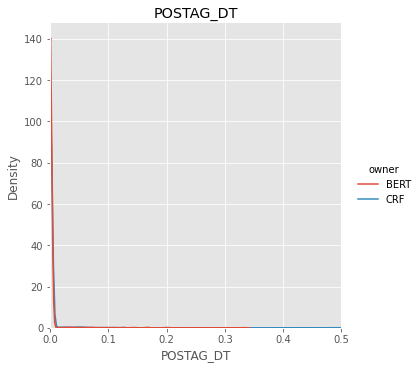

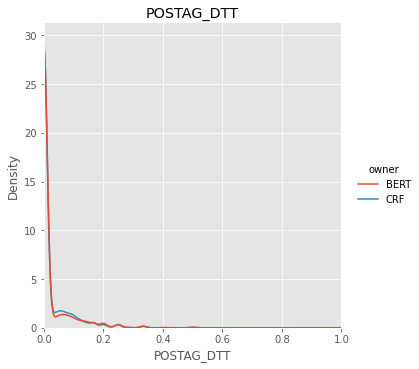

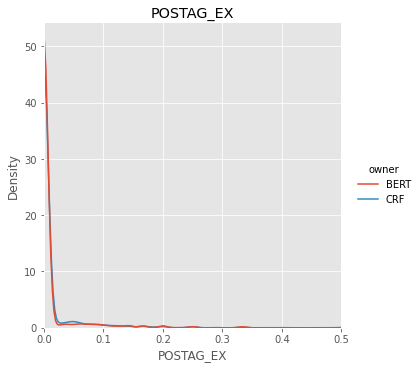

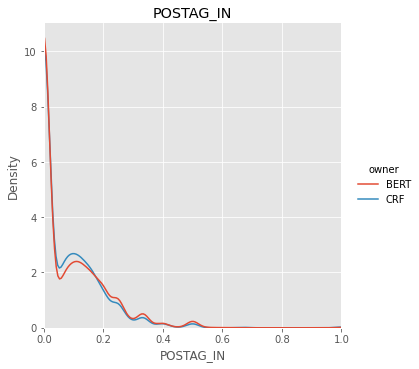

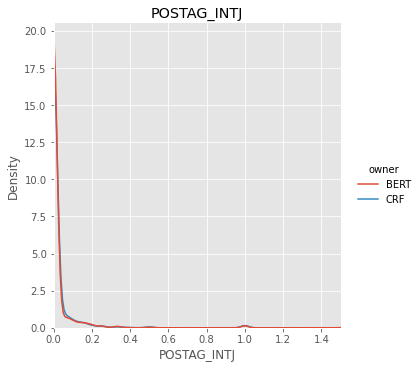

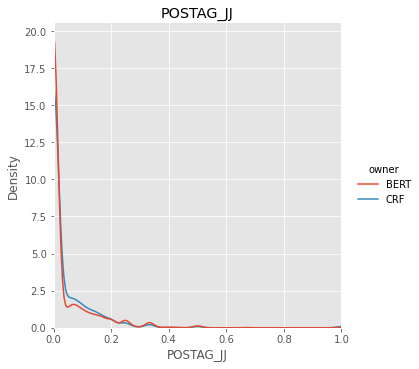

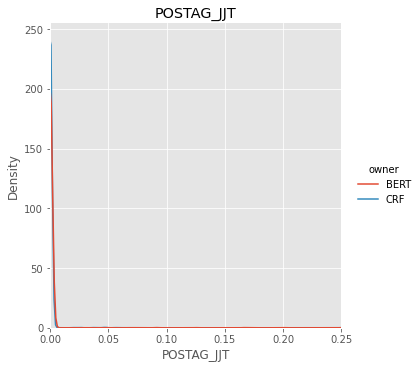

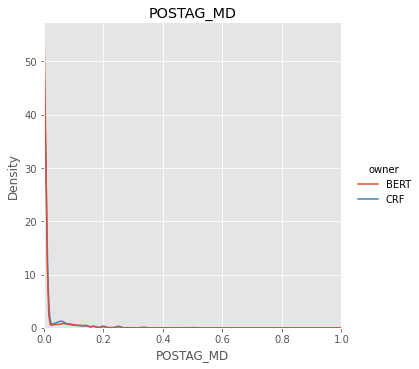

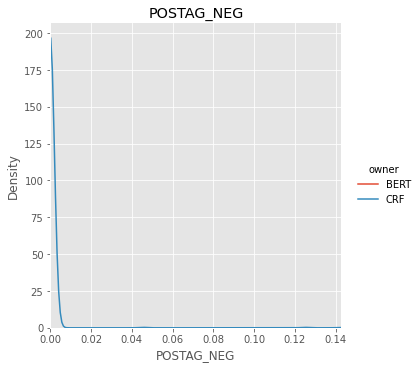

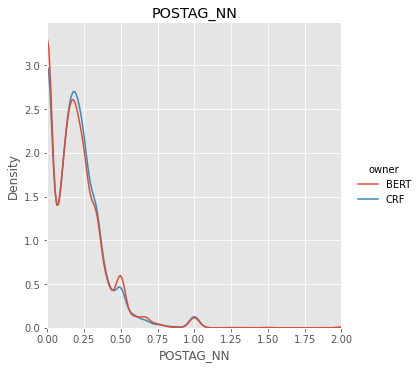

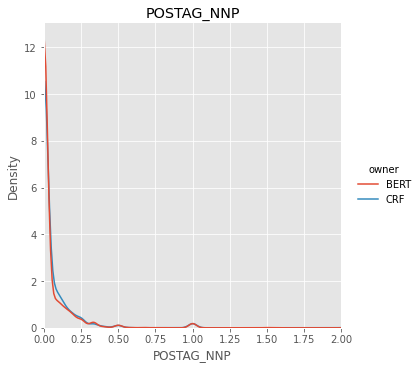

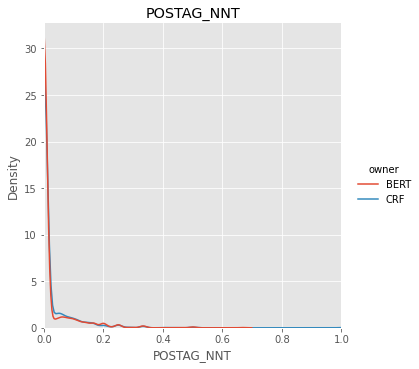

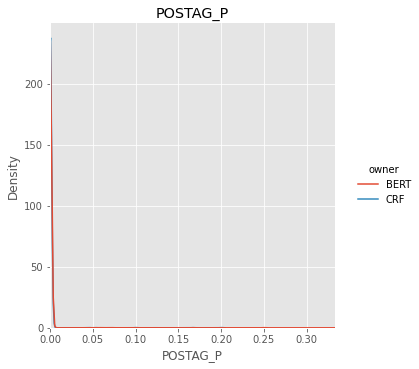

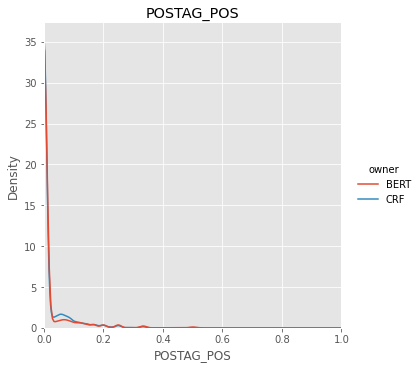

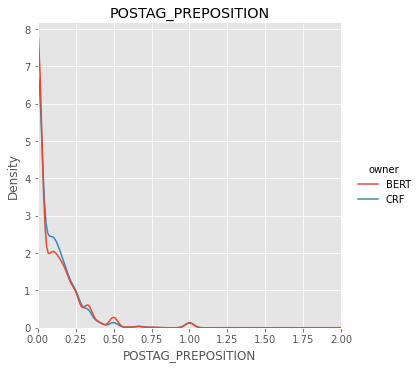

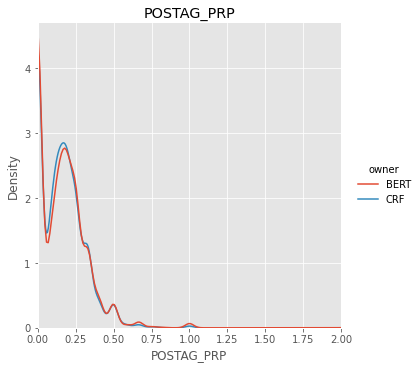

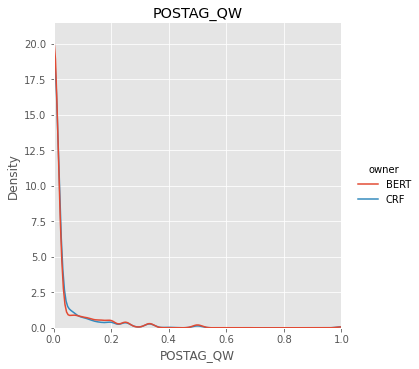

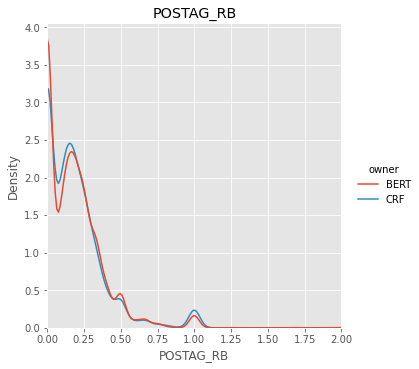

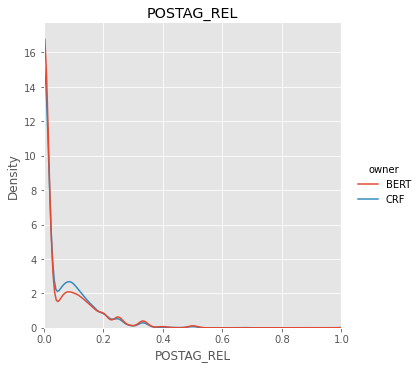

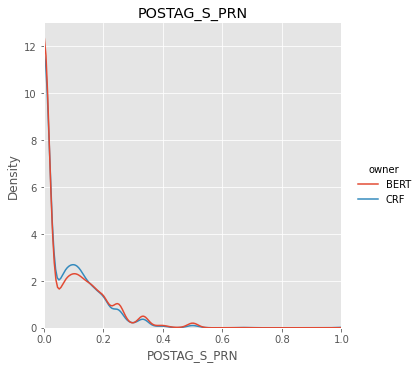

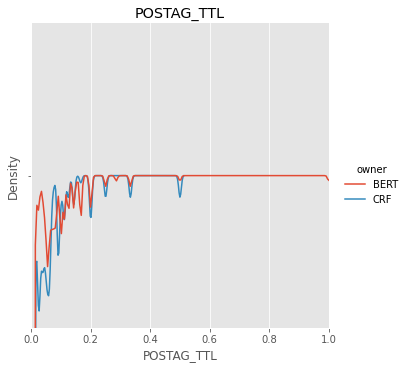

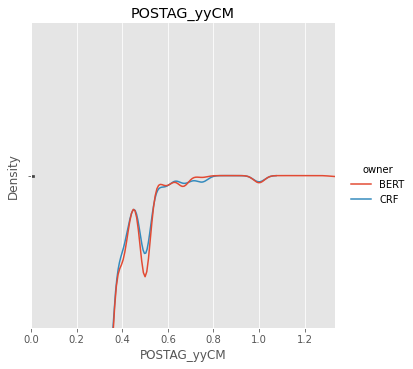

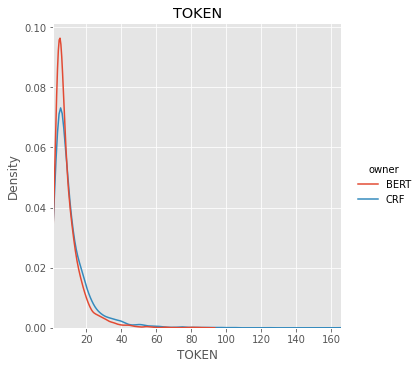

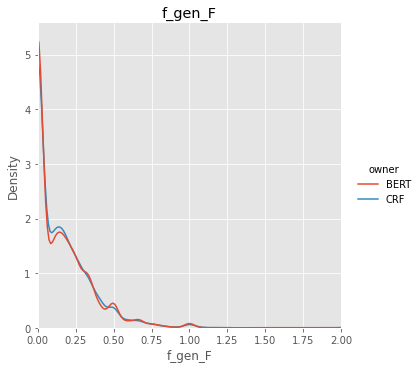

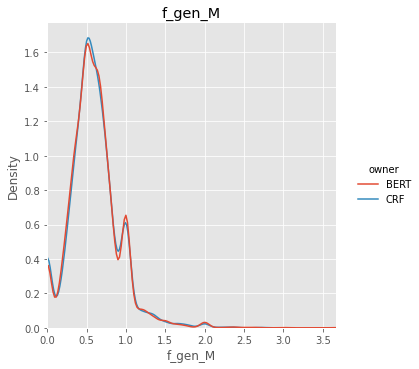

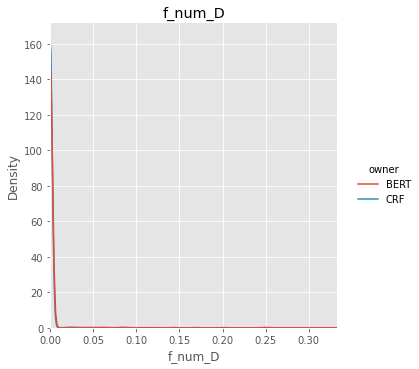

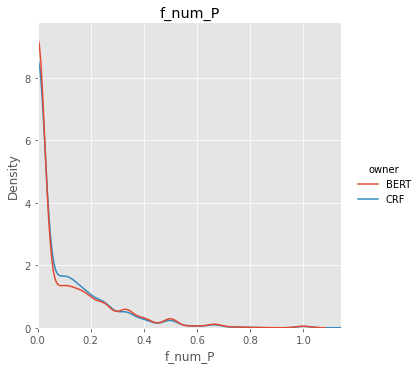

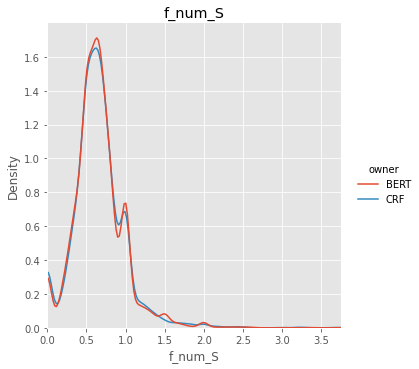

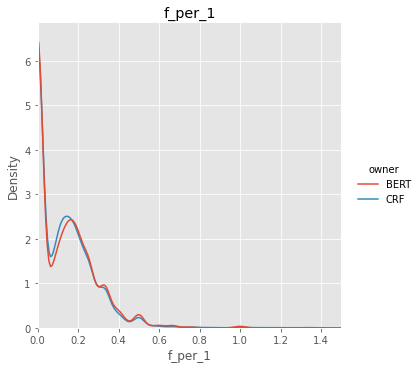

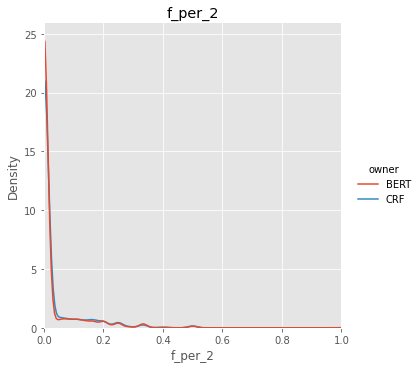

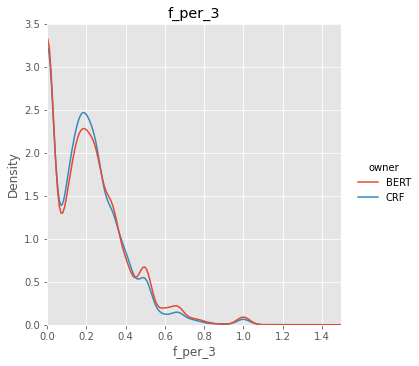

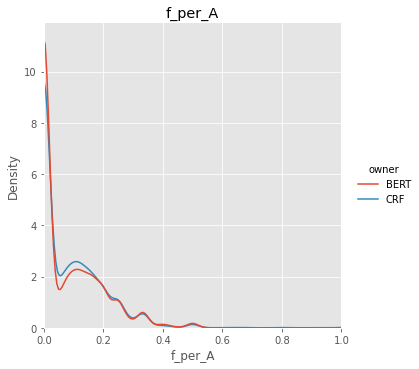

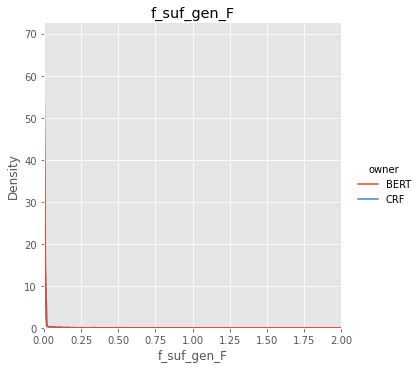

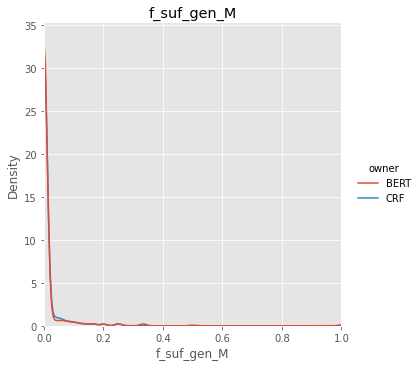

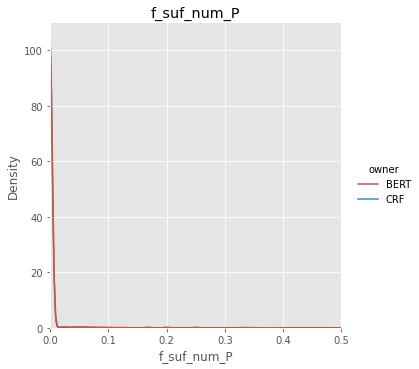

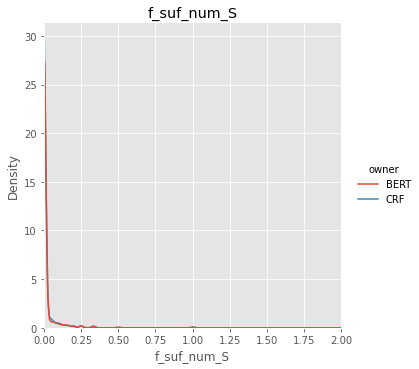

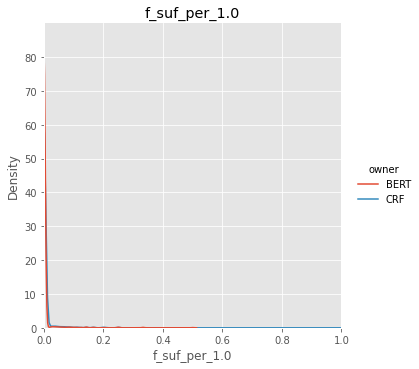

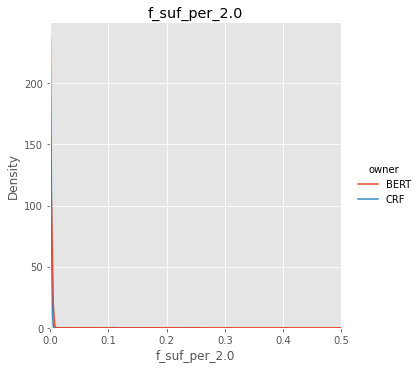

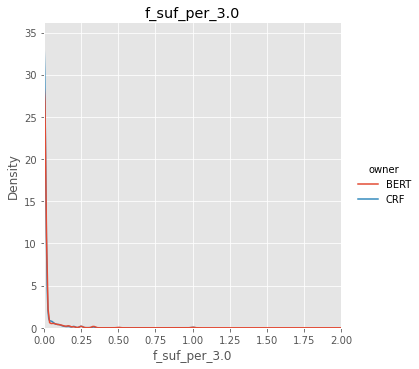

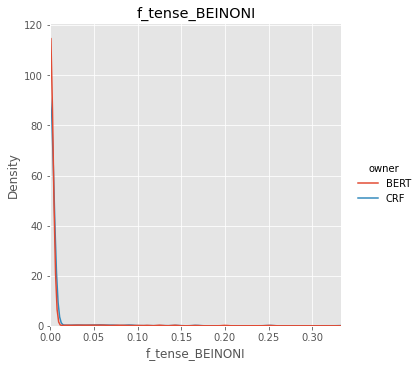

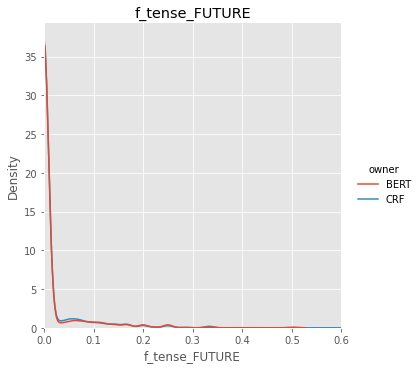

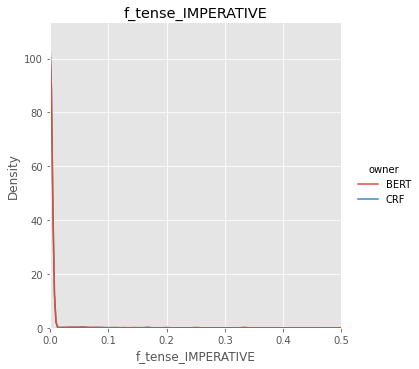

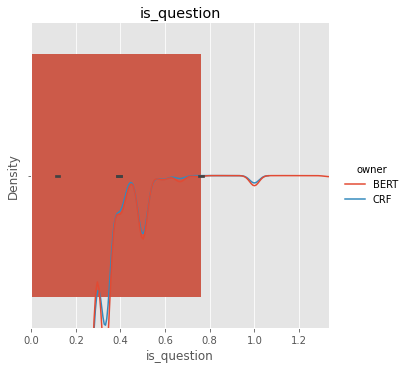

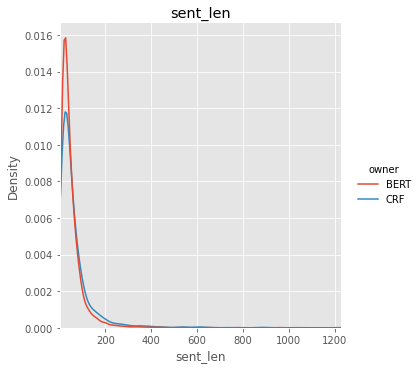

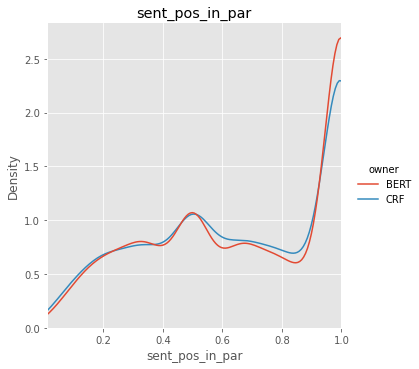

In [124]:
for col in plot_cols:
# col='POSTAG_TTL'
    if uniq_err[col].nunique()<3:
        type_plot='bar'
        sns_plot =  sns.barplot(data=uniq_err,
                            x=col,
                            hue='owner',
                           )
    else:
        type_plot='kde'
        sns_plot =  sns.displot(data=uniq_err,
                                    x=col,
                                    kind=type_plot,
                                    hue='owner',
                                    common_norm=False
                                   )
        sns_plot.set(xlim=(uniq_err[col].min(),uniq_err[col].max()))
    sns_plot.set(title=col)

<ipython-input-135-23006eac0449>:6: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  sns_plot.set(xlim=(uniq_err[col].min(),uniq_err[col].max()))


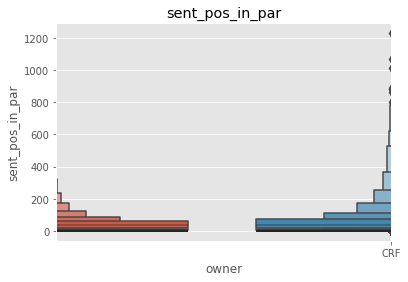

In [135]:
for col in plot_cols:
    sns_plot =  sns.boxenplot(data=uniq_err,
                                x='owner',
                              y=col
                               )
    sns_plot.set(xlim=(uniq_err[col].min(),uniq_err[col].max()))
    sns_plot.set(title=col)

<Figure size 1080x576 with 0 Axes>

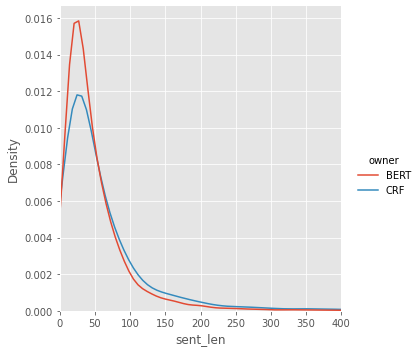

In [138]:
plt.figure(figsize = (15,8))

sns_plot =  sns.displot(data=uniq_err,
                                    x='sent_len',
                                    kind=type_plot,
                                    hue='owner',
                                    common_norm=False
                                   )
sns_plot.set(xlim=(0,400))

[Text(0.5, 1.0, 'sent_len')]

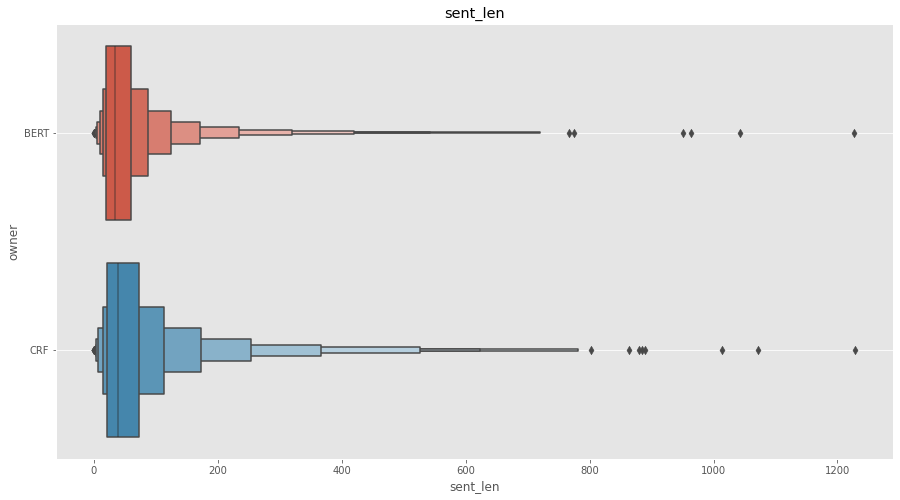

In [132]:
col='sent_len'
plt.figure(figsize = (15,8))
par_len_sent_b = sns.boxenplot(data=uniq_err,
                               y='owner',
                               x=col,
#                                hue='owner'
                              )
par_len_sent_b.grid()
par_len_sent_b.set(title=col)

[Text(0.5, 1.0, 'TOKEN')]

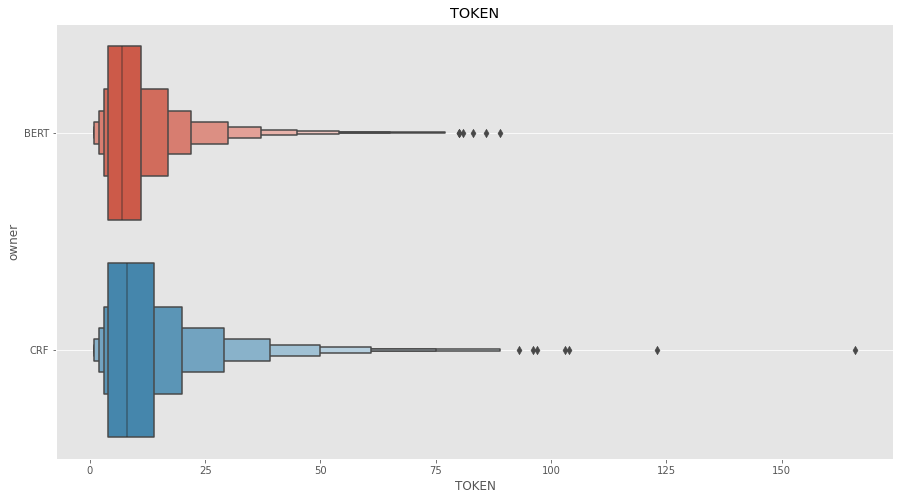

In [133]:
col='TOKEN'
plt.figure(figsize = (15,8))
par_len_sent_b = sns.boxenplot(data=uniq_err,
                               y='owner',
                               x=col,
#                                hue='owner'
                              )
par_len_sent_b.grid()
par_len_sent_b.set(title=col)

In [160]:
imp.reload(classes)


<module 'classes' from './src/classes.py'>

In [193]:
all_pred_crf01['crf_true'].sum()

9856

In [200]:
imp.reload(classes)

<module 'classes' from './src/classes.py'>

In [201]:
mea=classes.MyErrorAnalyzer(dir_name,all_pred_crf01)
mea.error_db

init >> MyErrorAnalyzer 


doc_idx  sent_idx  fp_bert  fn_bert  fp_crf  fn_crf fp_owner fn_owner
0            1         0     True    False   False   False     BERT     None
1            1         1    False    False   False   False     None     None
2            1         2    False    False   False   False     None     None
3            1         3    False    False   False   False     None     None
4            1         4     True    False   False   False     BERT     None
...        ...       ...      ...      ...     ...     ...      ...      ...
38429       79       254    False    False   False   False     None     None
38430       79       255    False    False   False   False     None     None
38431       79       256    False    False   False   False     None     None
38432       79       257    False    False   False   False     None     None
38433       79       258    False    False   False   False     None     None

[38434 rows x 8 columns]

In [202]:
mea.error_db['fp_crf'].sum()

1767

In [203]:
fp_fn_error_db=mea.error_db.merge(sent_label_db,left_on=['doc_idx','sent_idx'],right_on=['file_idx','sent_idx'],validate='one_to_one')
# fp_fn_error_db
fp_fn_error_db=fp_fn_error_db.merge(sent_pos_count_db,left_on=['doc_idx_x','sent_idx'],right_on=['doc_idx','sent_idx'],validate='one_to_one')


In [210]:
cols=fp_fn_error_db.columns.tolist()
plot_cols = [c for c in cols if not any(i in c for i in ['owner','uniq','doc','idx','predicted','correct','true','text','type'])]
plot_cols.sort()

In [205]:
common_utils.save_db(fp_fn_error_db,dir_name,'fp_fn_error_owner')

Saving /scratch/sim_reg9/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/duplicate/fp_fn_error_owner.csv, 
index False
float_format %.5f


In [334]:
imp.reload(classes)

<module 'classes' from './src/classes.py'>

In [335]:
imp.reload(classes)
mea=classes.MyErrorAnalyzer(dir_name,all_pred_crf01)


init >> MyErrorAnalyzer 


In [336]:
mea.error_db

doc_idx  sent_idx  fp_bert  fn_bert  fp_crf  fn_crf  fn_ens  fp_ens  \
0            1         0     True    False   False   False   False   False   
1            1         1    False    False   False   False   False   False   
2            1         2    False    False   False   False   False   False   
3            1         3    False    False   False   False   False   False   
4            1         4     True    False   False   False   False   False   
...        ...       ...      ...      ...     ...     ...     ...     ...   
38429       79       254    False    False   False   False   False   False   
38430       79       255    False    False   False   False   False   False   
38431       79       256    False    False   False   False   False   False   
38432       79       257    False    False   False   False   False   False   
38433       79       258    False    False   False   False   False   False   

      fp_owner fn_owner     ens_fp_action ens_fn_action ens_action  
0         BERT     None  FIXED_BERT_ERROR          None      FIXED  
1         None     None              None          None       None  
2         None     None              None          None       None  
3         None     None              None          None       None  
4         BERT     None  FIXED_BERT_ERROR          None      FIXED  
...        ...      ...               ...           ...        ...  
38429     None     None              None          None       None  
38430     None     None              None          None       None  
38431     None     None              None          None       None  
38432     None     None              None          None       None  
38433     None     None              None          None       None  

[38434 rows x 13 columns]

<AxesSubplot:>

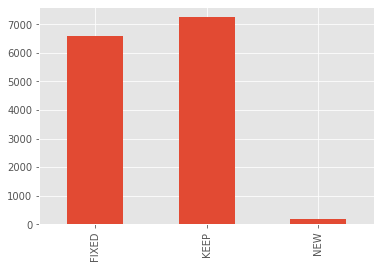

In [338]:
(mea.error_db['ens_action'].value_counts(sort=False)).plot.bar()

In [339]:
merged_error_db

doc  sent_idx  bert_correct  crf_correct  uniq_bert  uniq_crf owner  \
0        1         0         False         True       True     False  BERT   
1        1         1          True         True      False     False  None   
2        1         2          True         True      False     False  None   
3        1         3          True         True      False     False  None   
4        1         4         False         True       True     False  BERT   
...    ...       ...           ...          ...        ...       ...   ...   
38429   79       254          True         True      False     False  None   
38430   79       255          True         True      False     False  None   
38431   79       256          True         True      False     False  None   
38432   79       257          True         True      False     False  None   
38433   79       258          True         True      False     False  None   

       is_nar_x  file_idx  is_question  ...   f_per_2   f_per_3   f_per_A  \
0             0         1          0.0  ...  0.000000  0.000000  0.142857   
1             0         1          0.0  ...  0.000000  0.000000  0.000000   
2             0         1          1.0  ...  0.000000  0.000000  0.000000   
3             0         1          0.0  ...  0.000000  0.000000  0.000000   
4             0         1          0.0  ...  0.200000  0.000000  0.000000   
...         ...       ...          ...  ...       ...       ...       ...   
38429         0        79          0.0  ...  0.000000  0.000000  0.000000   
38430         0        79          0.0  ...  0.117647  0.058824  0.117647   
38431         0        79          0.0  ...  0.066667  0.200000  0.000000   
38432         0        79          0.0  ...  0.052632  0.368421  0.157895   
38433         0        79          0.0  ...  0.090909  0.181818  0.000000   

       f_tense_BEINONI  f_tense_FUTURE  f_tense_IMPERATIVE  f_tense_PAST  \
0             0.000000        0.000000                 0.0      0.000000   
1             0.000000        0.000000                 0.0      0.000000   
2             0.000000        0.000000                 0.0      0.000000   
3             0.000000        0.000000                 0.0      0.000000   
4             0.000000        0.000000                 0.0      0.000000   
...                ...             ...                 ...           ...   
38429         0.000000        0.000000                 0.0      0.000000   
38430         0.000000        0.000000                 0.0      0.000000   
38431         0.066667        0.000000                 0.0      0.000000   
38432         0.000000        0.210526                 0.0      0.105263   
38433         0.000000        0.136364                 0.0      0.045455   

       POSTAG_NEG POSTAG_yyCM POSTAG_TTL  
0             NaN         NaN        NaN  
1             NaN         NaN        NaN  
2             NaN         NaN        NaN  
3             NaN         NaN        NaN  
4             NaN         NaN        NaN  
...           ...         ...        ...  
38429         NaN         NaN        NaN  
38430         NaN         NaN        NaN  
38431         NaN         NaN        NaN  
38432         NaN         NaN        NaN  
38433         NaN         NaN        NaN  

[38434 rows x 82 columns]

In [340]:
merged_error_db=merged_error_db.merge(mea.error_db,left_on=['doc','sent_idx'],right_on=['doc_idx','sent_idx'],validate='one_to_one')

In [341]:
merged_error_db

doc  sent_idx  bert_correct  crf_correct  uniq_bert  uniq_crf owner  \
0        1         0         False         True       True     False  BERT   
1        1         1          True         True      False     False  None   
2        1         2          True         True      False     False  None   
3        1         3          True         True      False     False  None   
4        1         4         False         True       True     False  BERT   
...    ...       ...           ...          ...        ...       ...   ...   
38429   79       254          True         True      False     False  None   
38430   79       255          True         True      False     False  None   
38431   79       256          True         True      False     False  None   
38432   79       257          True         True      False     False  None   
38433   79       258          True         True      False     False  None   

       is_nar_x  file_idx  is_question  ... fn_bert  fp_crf  fn_crf  fn_ens  \
0             0         1          0.0  ...   False   False   False   False   
1             0         1          0.0  ...   False   False   False   False   
2             0         1          1.0  ...   False   False   False   False   
3             0         1          0.0  ...   False   False   False   False   
4             0         1          0.0  ...   False   False   False   False   
...         ...       ...          ...  ...     ...     ...     ...     ...   
38429         0        79          0.0  ...   False   False   False   False   
38430         0        79          0.0  ...   False   False   False   False   
38431         0        79          0.0  ...   False   False   False   False   
38432         0        79          0.0  ...   False   False   False   False   
38433         0        79          0.0  ...   False   False   False   False   

       fp_ens  fp_owner  fn_owner     ens_fp_action ens_fn_action ens_action  
0       False      BERT      None  FIXED_BERT_ERROR          None      FIXED  
1       False      None      None              None          None       None  
2       False      None      None              None          None       None  
3       False      None      None              None          None       None  
4       False      BERT      None  FIXED_BERT_ERROR          None      FIXED  
...       ...       ...       ...               ...           ...        ...  
38429   False      None      None              None          None       None  
38430   False      None      None              None          None       None  
38431   False      None      None              None          None       None  
38432   False      None      None              None          None       None  
38433   False      None      None              None          None       None  

[38434 rows x 94 columns]

init >> MyErrorAnalyzer 


/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


AttributeError: 'Rectangle' object has no property 'hue'

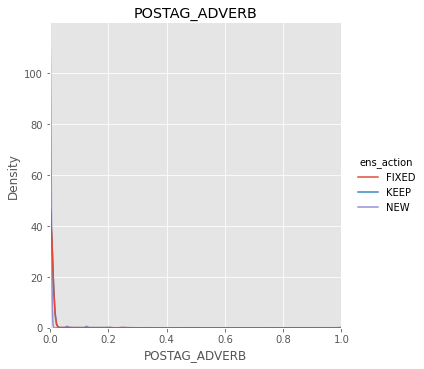

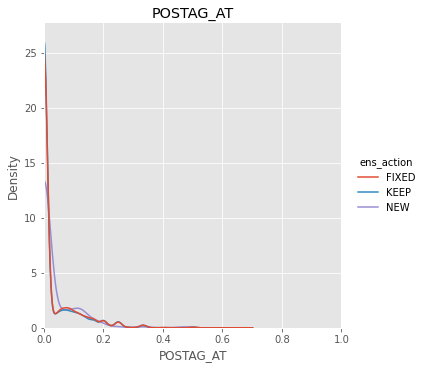

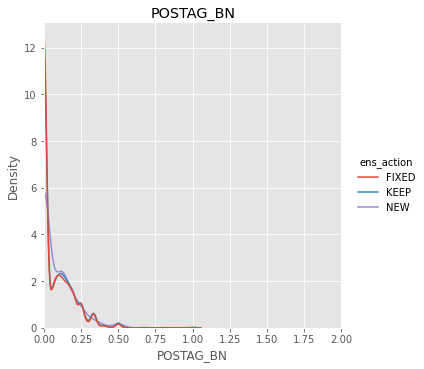

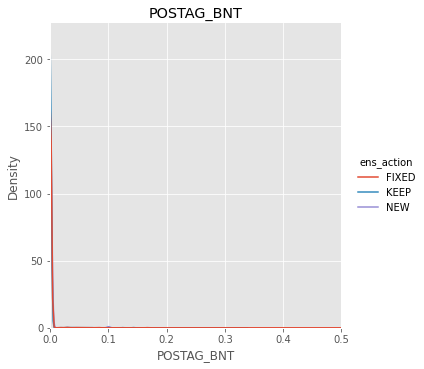

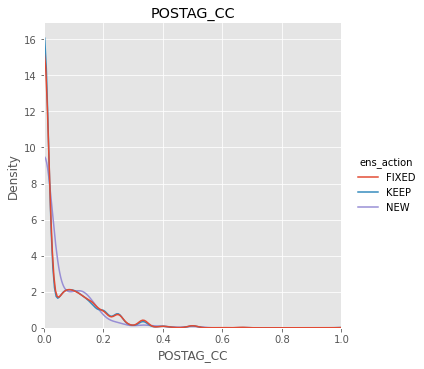

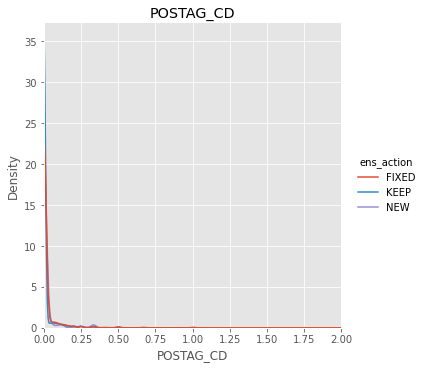

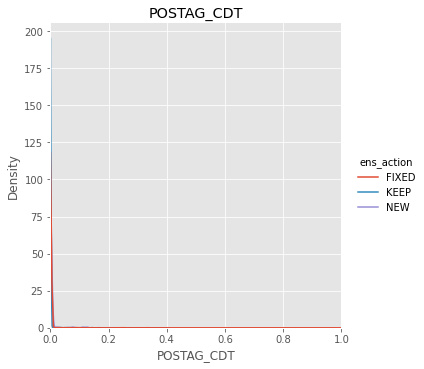

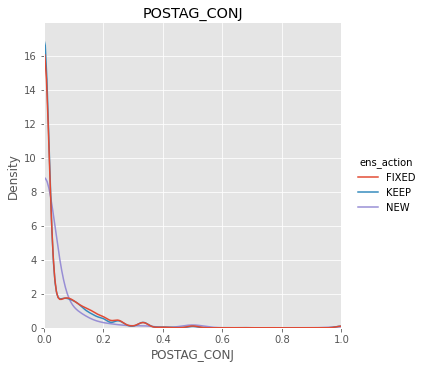

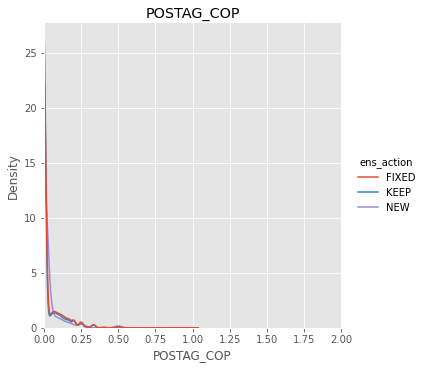

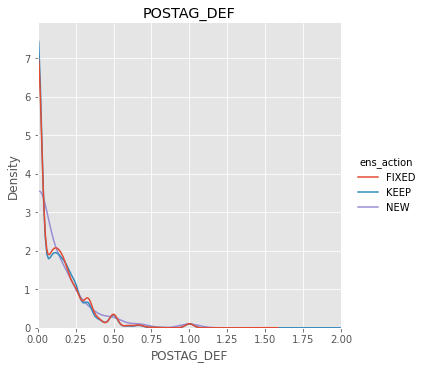

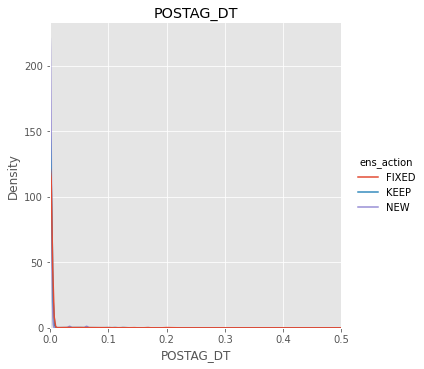

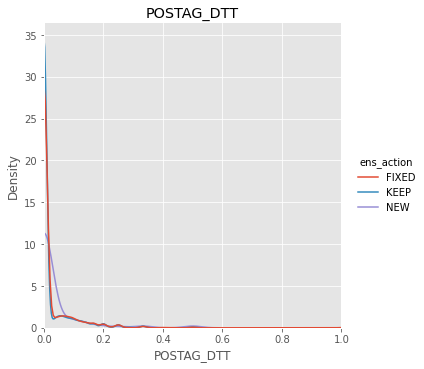

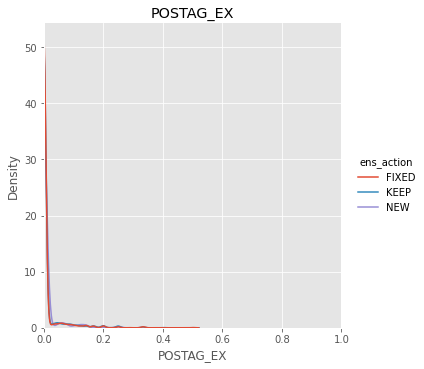

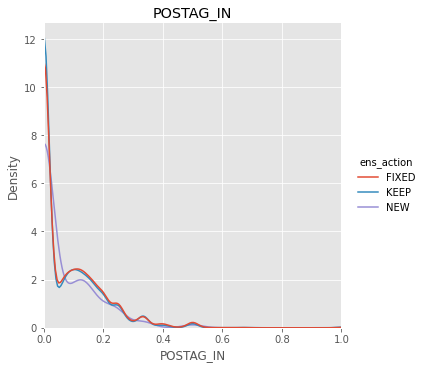

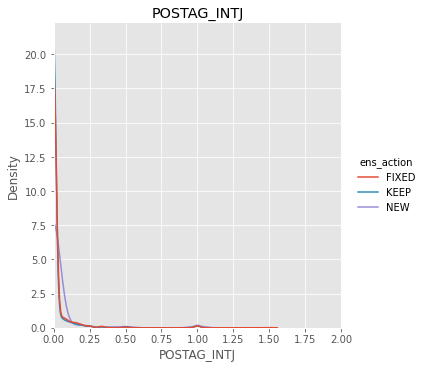

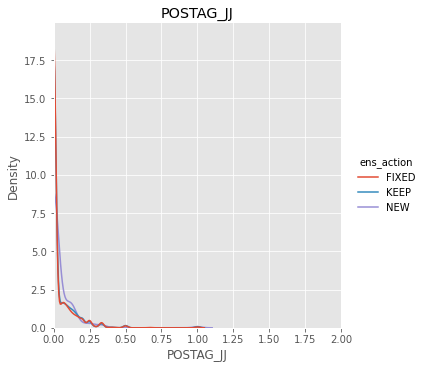

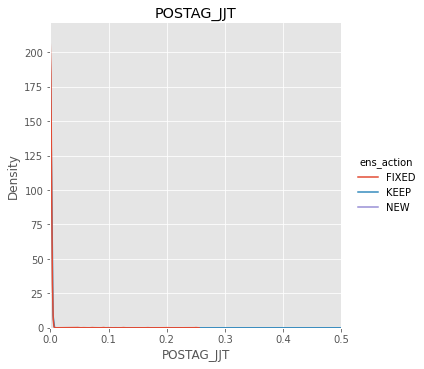

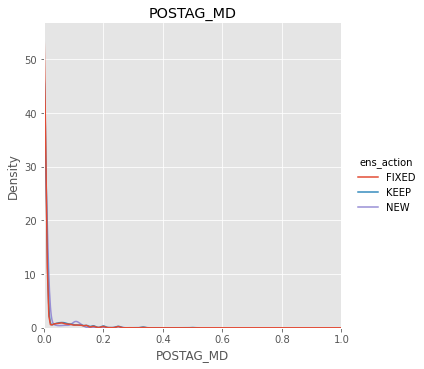

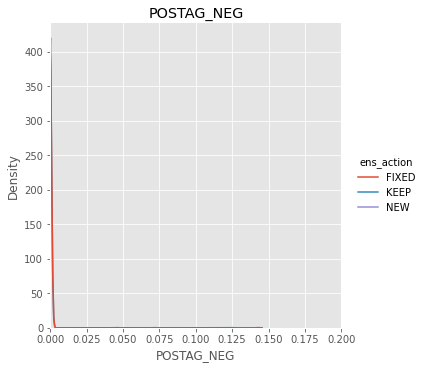

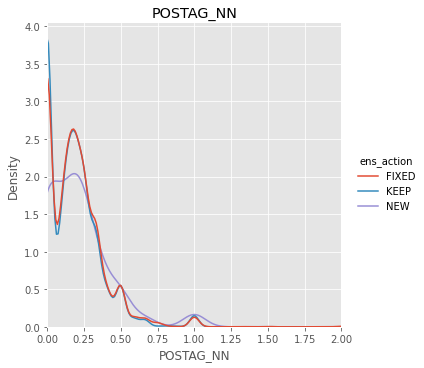

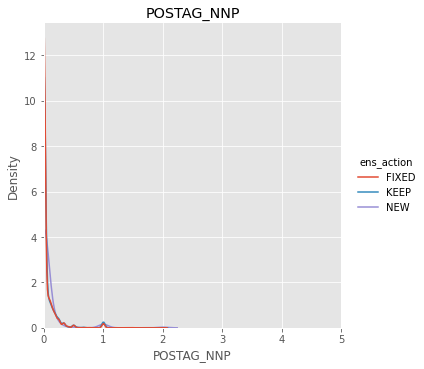

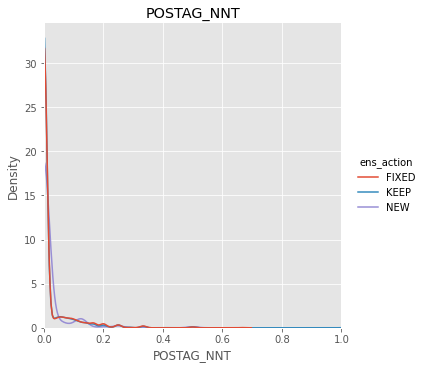

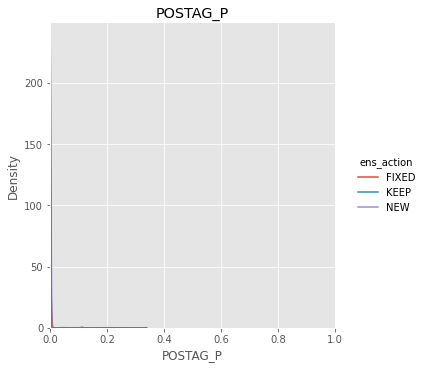

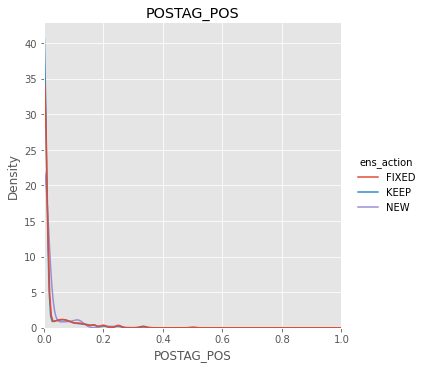

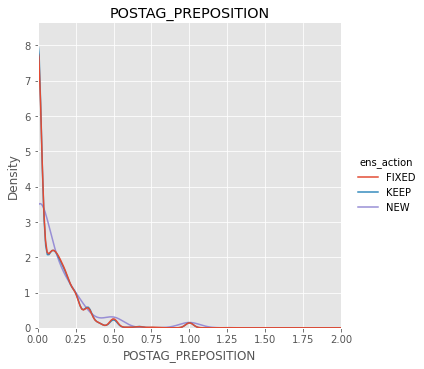

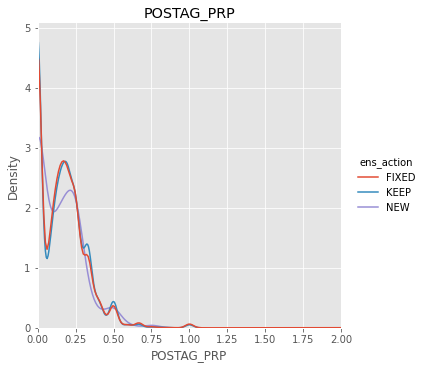

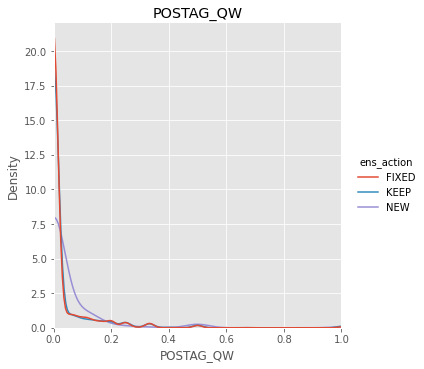

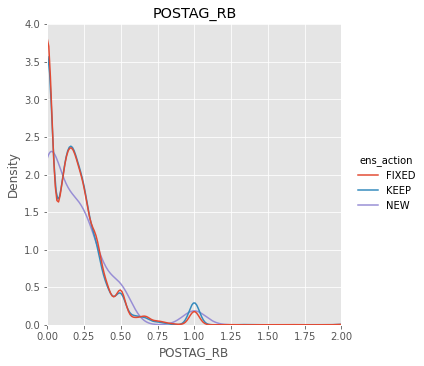

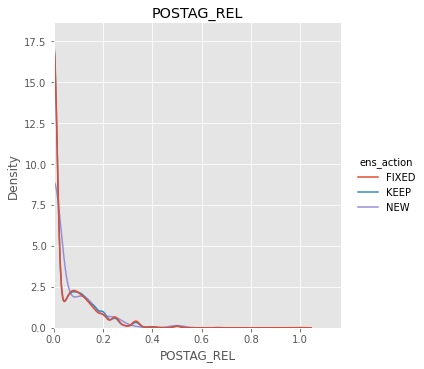

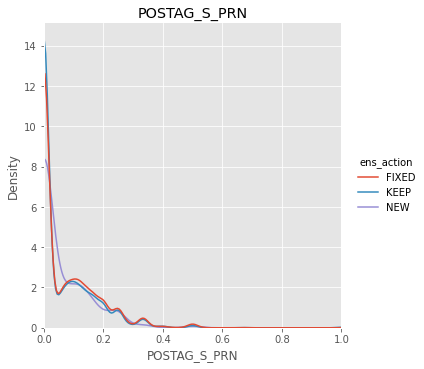

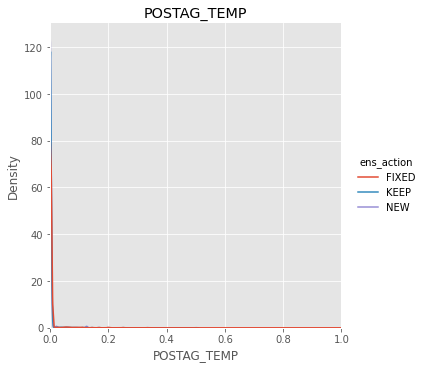

In [348]:
imp.reload(classes)
mea_plot=classes.MyErrorAnalyzer(dir_name,all_pred_crf01)
mea_plot.plot_fp(merged_error_db,hue='ens_action')

<AxesSubplot:>

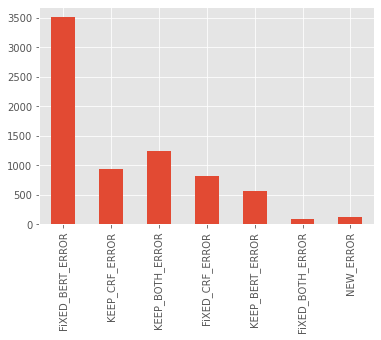

In [268]:
col='ens_fp_action'
(mea.error_db[col].value_counts(sort=False)).plot.bar()

In [273]:
mea.error_db['ens_fp_action'].value_counts(sort=False)

FiXED_BERT_ERROR    3511
KEEP_CRF_ERROR       938
KEEP_BOTH_ERROR     1251
FiXED_CRF_ERROR      829
KEEP_BERT_ERROR      573
FiXED_BOTH_ERROR      99
NEW_ERROR            133
Name: ens_fp_action, dtype: int64

<AxesSubplot:>

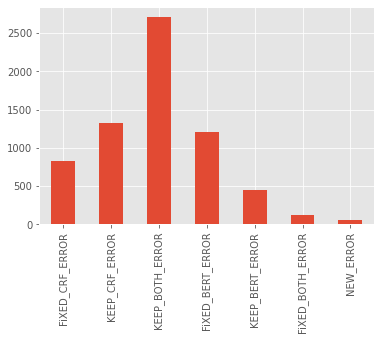

In [271]:
col='ens_fn_action'
(mea.error_db[col].value_counts(sort=False)).plot.bar()

In [274]:
mea.error_db['ens_fn_action'].value_counts(sort=False)

FiXED_CRF_ERROR      827
KEEP_CRF_ERROR      1321
KEEP_BOTH_ERROR     2708
FiXED_BERT_ERROR    1207
KEEP_BERT_ERROR      452
FiXED_BOTH_ERROR     127
NEW_ERROR             60
Name: ens_fn_action, dtype: int64

In [304]:
mea.error_db['fp_owner'].value_counts()

BERT    4084
CRF     1767
BOTH    1350
Name: fp_owner, dtype: int64

In [305]:
mea.error_db['ens_fp_action'].value_counts()

FiXED_BERT_ERROR    3511
KEEP_BOTH_ERROR     1251
KEEP_CRF_ERROR       938
FiXED_CRF_ERROR      829
KEEP_BERT_ERROR      573
NEW_ERROR            133
FiXED_BOTH_ERROR      99
Name: ens_fp_action, dtype: int64

In [284]:
fn_fixed=mea.error_db[(~mea.error_db['ens_fn_action'].isna())&(mea.error_db['ens_fn_action'].str.contains("FiXED"))]['ens_fn_action'].value_counts().sum()

In [285]:
fn_kept=mea.error_db[(~mea.error_db['ens_fn_action'].isna())&(mea.error_db['ens_fn_action'].str.contains("KEEP"))]['ens_fn_action'].value_counts().sum()

In [292]:
fn_fixed*100/(fn_fixed+fn_kept),fn_kept

(32.53538090936465, 4481)

In [287]:
fp_fixed=mea.error_db[(~mea.error_db['ens_fp_action'].isna())&(mea.error_db['ens_fp_action'].str.contains("FiXED"))]['ens_fp_action'].value_counts().sum()
fp_kept=mea.error_db[(~mea.error_db['ens_fp_action'].isna())&(mea.error_db['ens_fp_action'].str.contains("KEEP"))]['ens_fp_action'].value_counts().sum()

In [288]:
fp_fixed*100/(fp_fixed+fp_kept)

61.64421608109985

In [291]:
fp_fixed+fp_kept,fp_fixed,fp_kept

(7201, 4439, 2762)

In [314]:
fp_fixed+fn_fixed, mea.error_db['fp_owner'].value_counts().sum()+mea.error_db['fn_owner'].value_counts().sum()

(6600, 13843)

In [306]:
mea.error_db['fp_owner'].count(),mea.error_db['fn_owner'].count()

(7201, 6642)

In [308]:
mea.error_db['fp_owner'].value_counts().sum()

7201

In [303]:
mea.error_db['ens_fn_action'].str.contains("FIXED").count()

6702

In [248]:
ens_error_db=fp_fn_error_db.merge(mea.error_db[['ens_error','doc_idx','sent_idx']],left_on=['doc_idx','sent_idx'],right_on=['doc_idx','sent_idx'],validate='one_to_one')

In [252]:
ens_error_db.loc[~ens_error_db['ens_error'].isna(),'sent_len'].describe()

count    7436.000000
mean       52.149274
std        64.364384
min         1.000000
25%        19.000000
50%        34.000000
75%        62.000000
max      1229.000000
Name: sent_len, dtype: float64

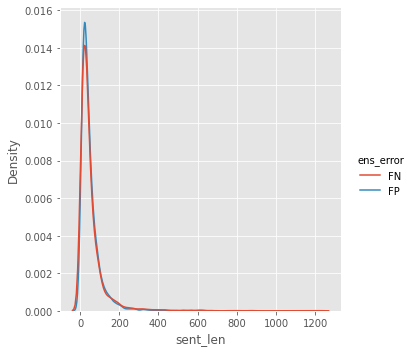

In [249]:
mea.error_db['ens_error']
sns_plot =  sns.displot(data=ens_error_db,
                            x='sent_len',
                            kind=type_plot,
                                    hue='ens_error',
                                    common_norm=False
                           )

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


AttributeError: 'Rectangle' object has no property 'hue'

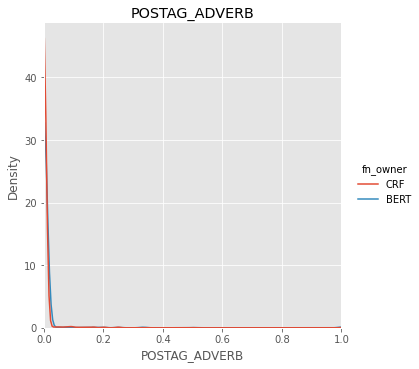

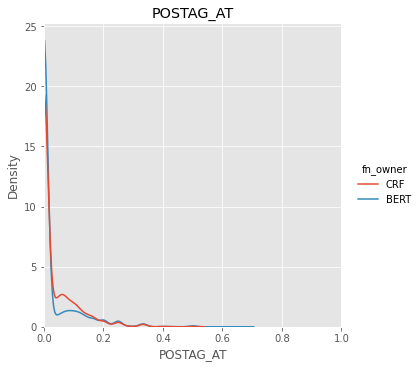

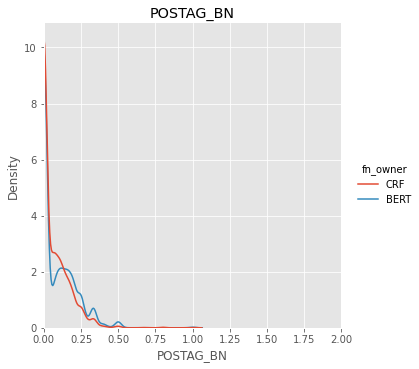

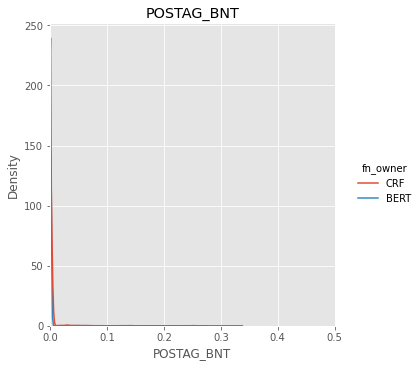

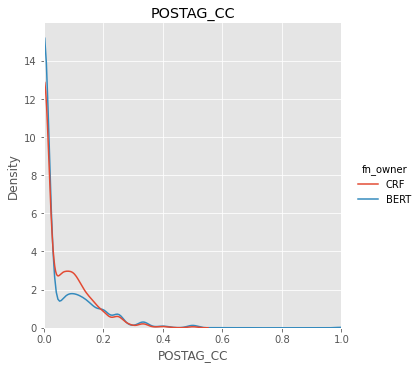

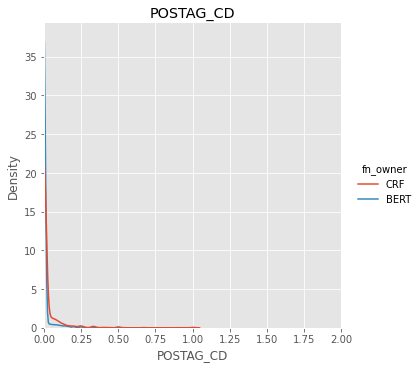

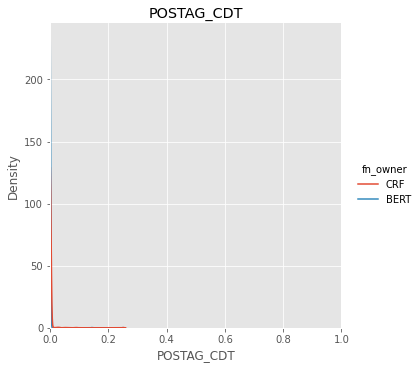

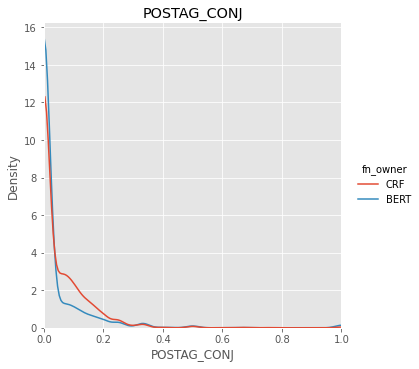

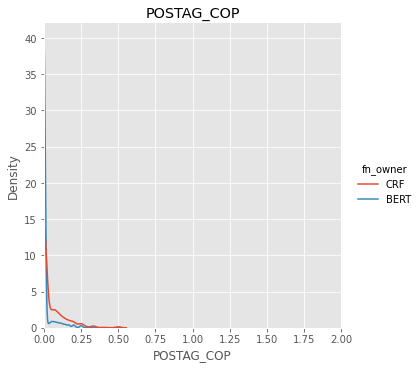

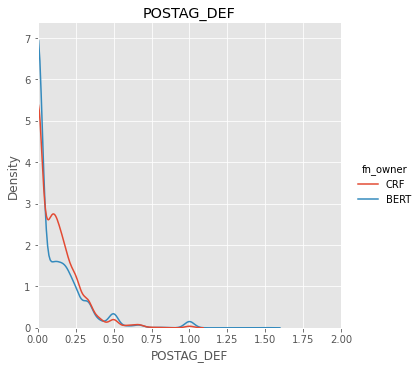

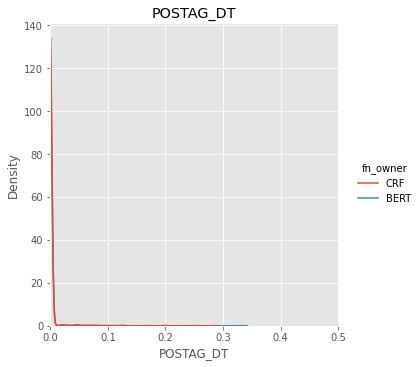

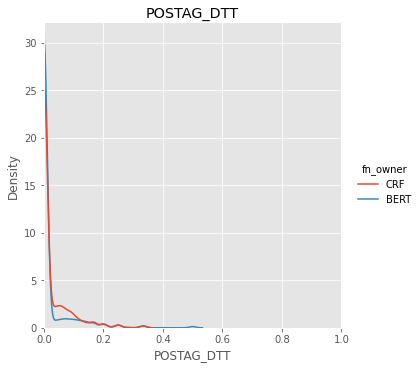

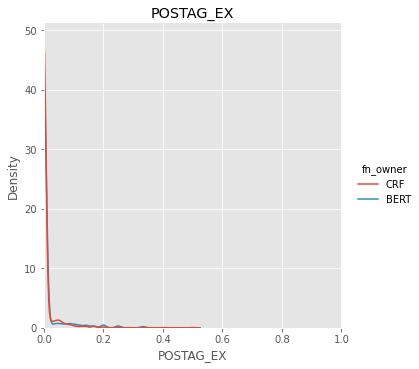

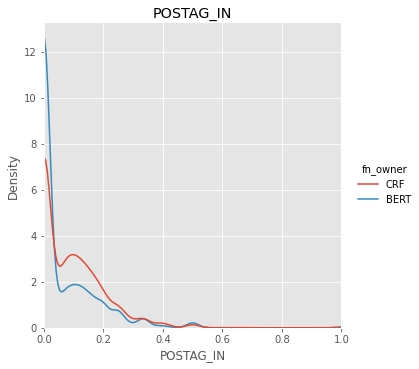

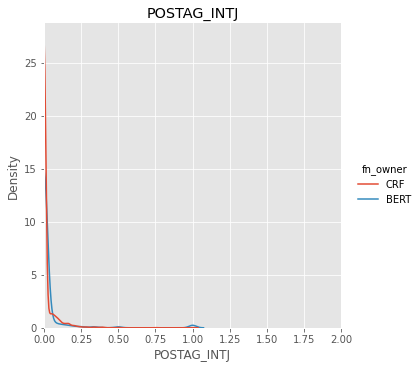

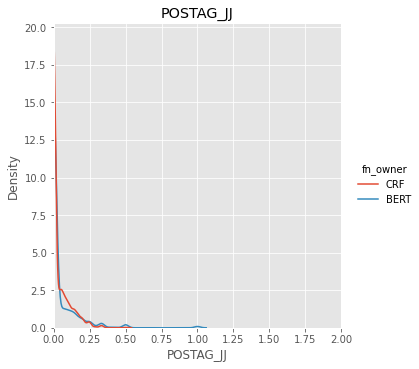

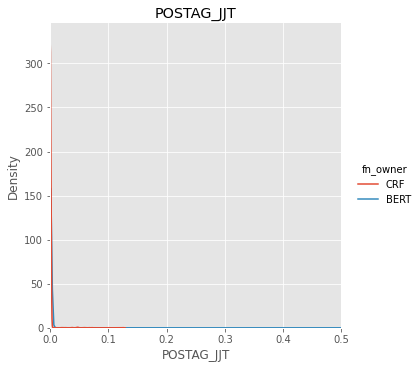

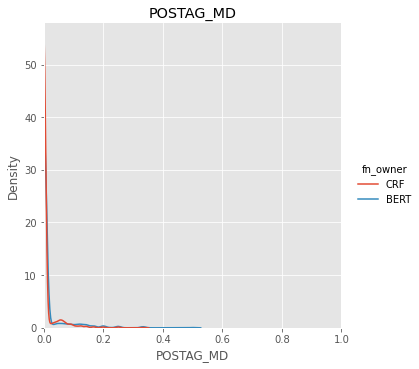

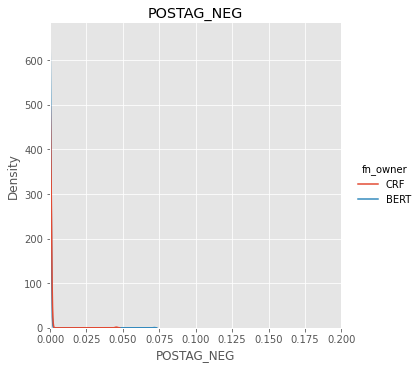

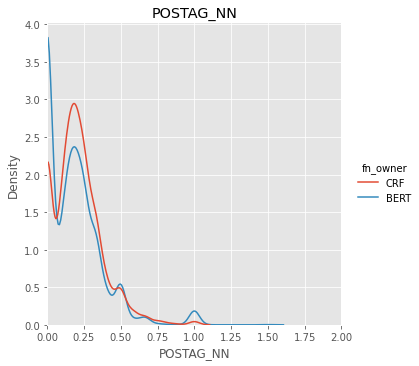

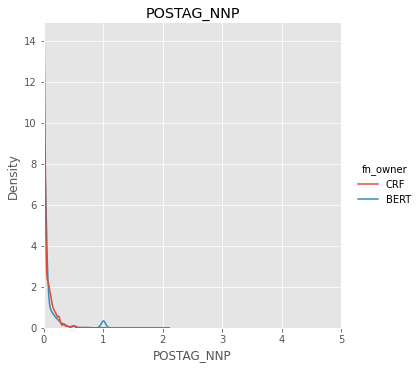

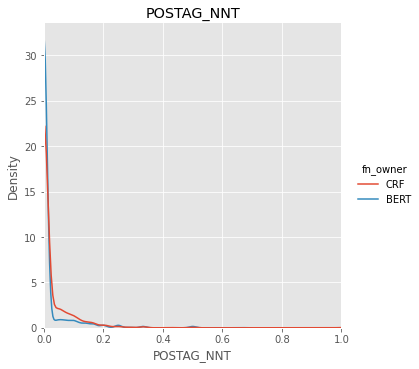

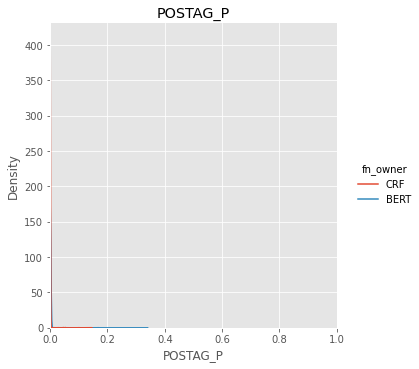

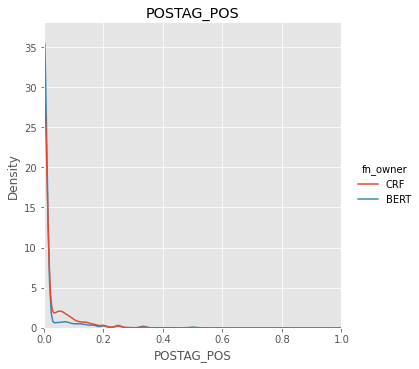

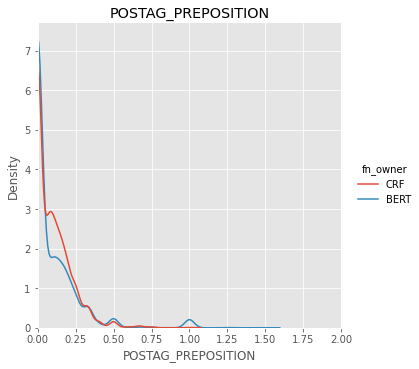

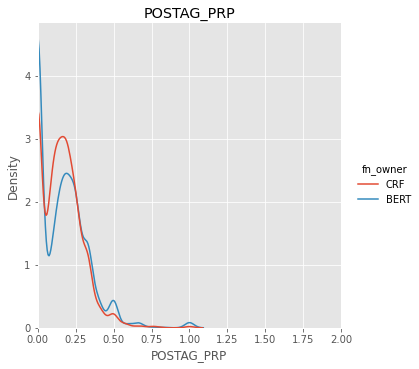

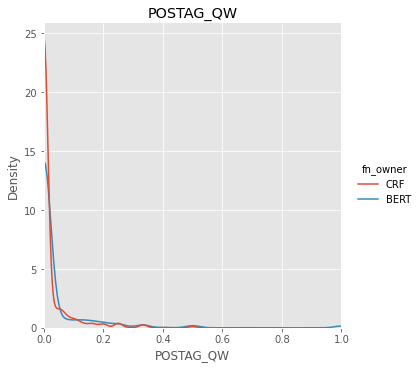

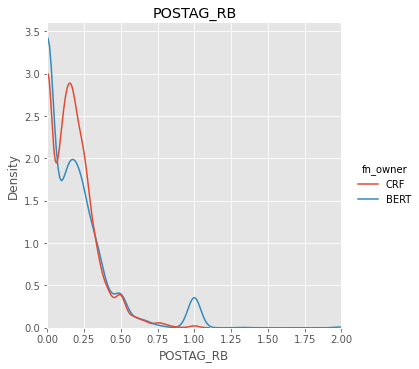

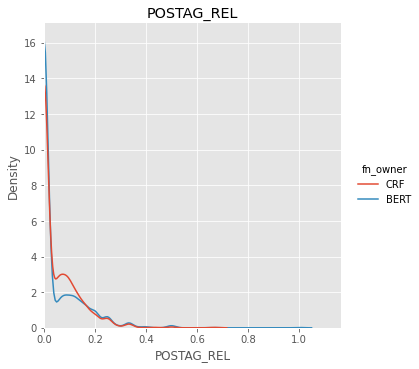

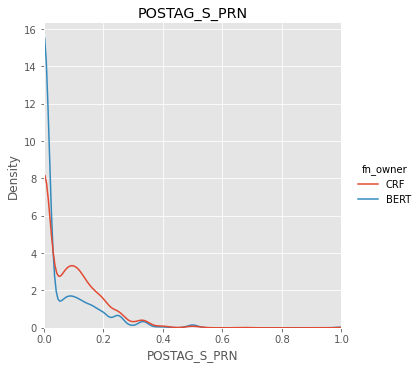

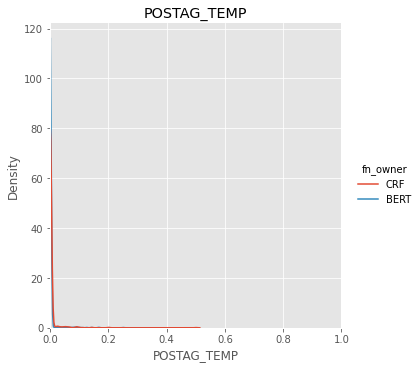

In [220]:
mea.plot_fpmea(fp_fn_error_db,plot_cols)

<AxesSubplot:>

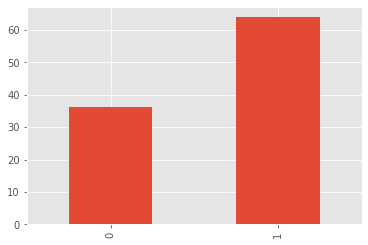

In [216]:
(fp_fn_error_db['is_client'].value_counts(normalize=True, sort=False)*100).plot.bar()

In [318]:
fp_fn_error_db['sent_len'].describe()

count    38434.000000
mean        51.014206
std         66.563055
min          1.000000
25%         18.000000
50%         33.000000
75%         60.000000
max       1661.000000
Name: sent_len, dtype: float64

TypeError: unsupported operand type(s) for /: 'method' and 'tuple'

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


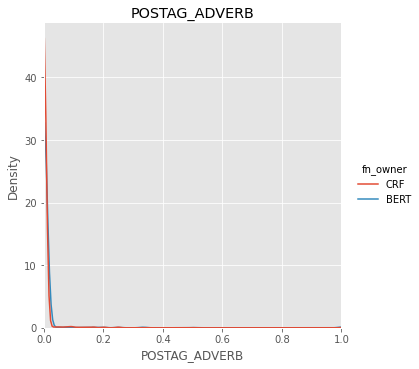

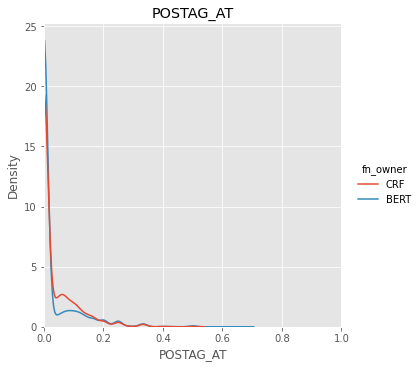

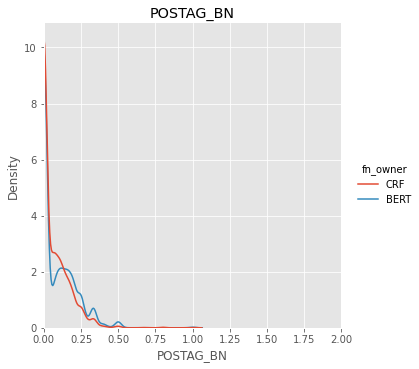

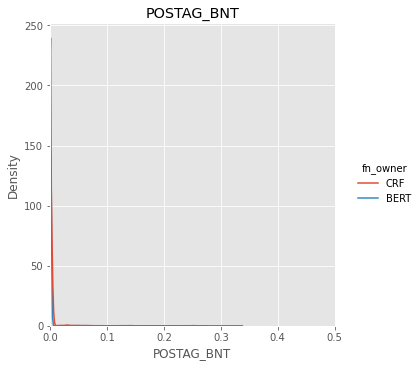

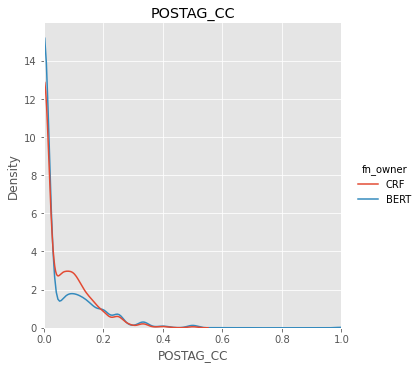

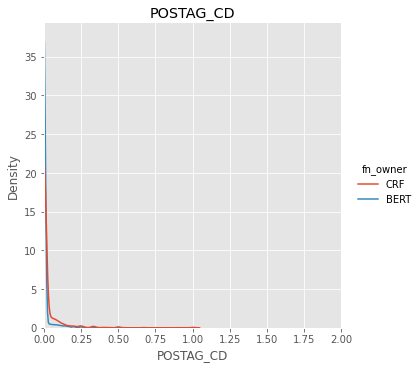

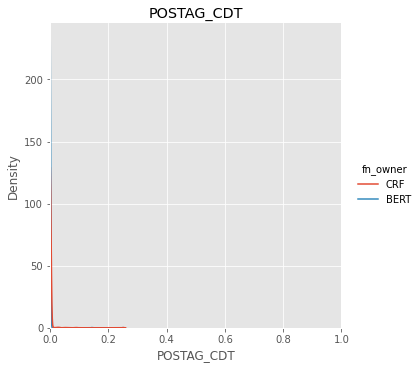

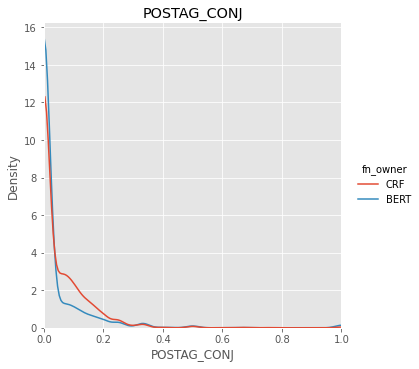

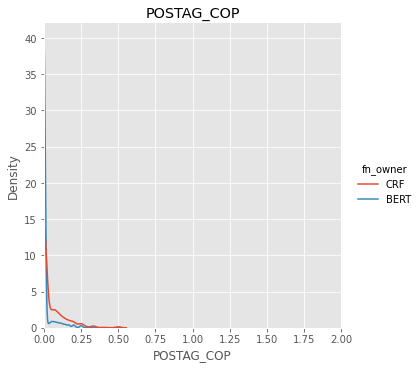

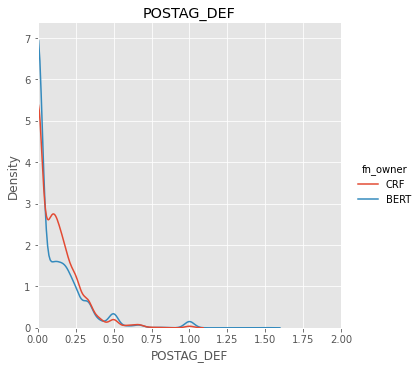

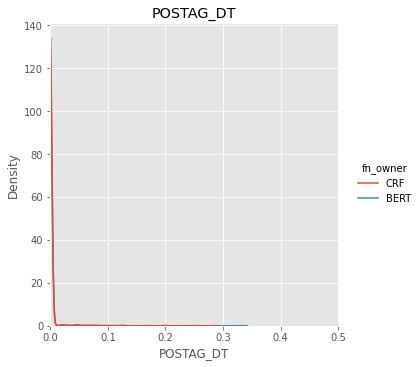

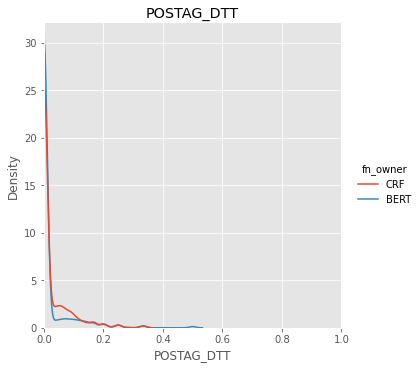

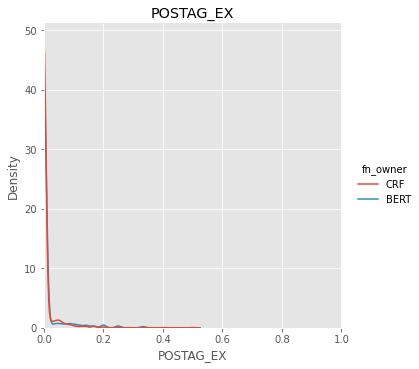

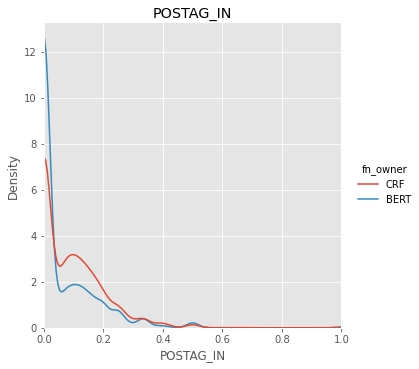

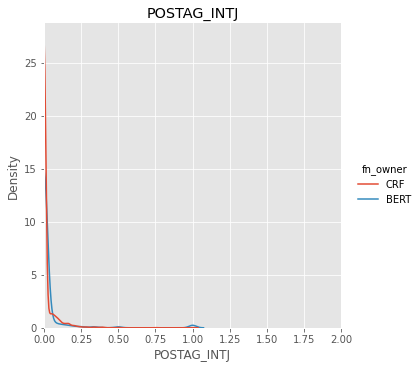

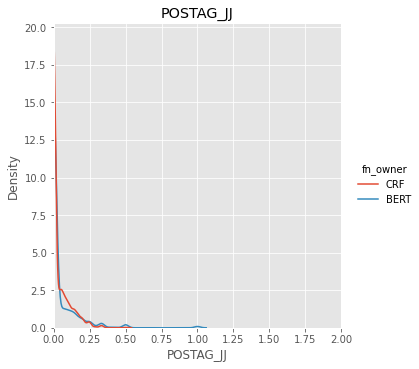

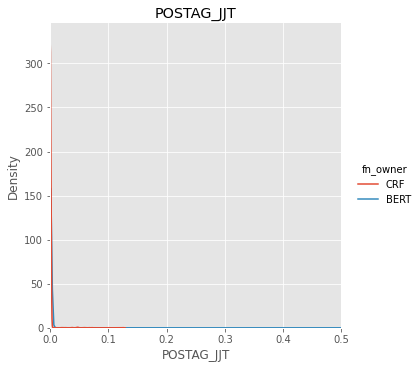

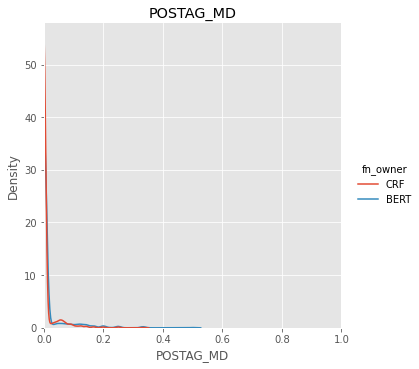

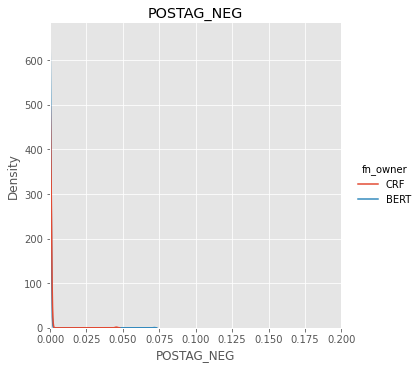

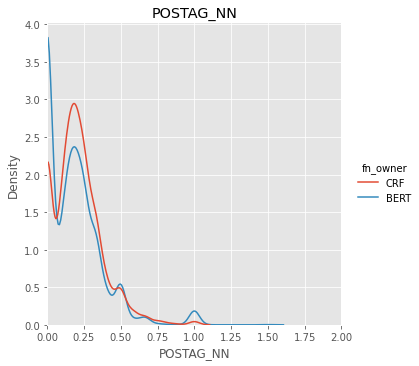

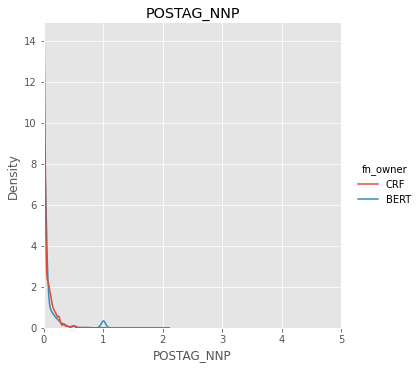

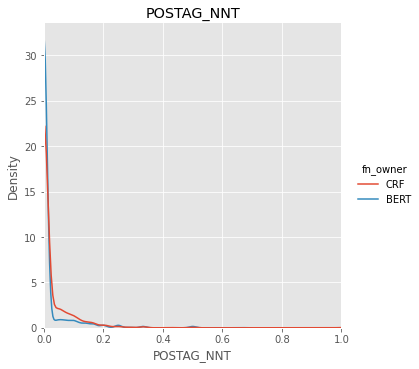

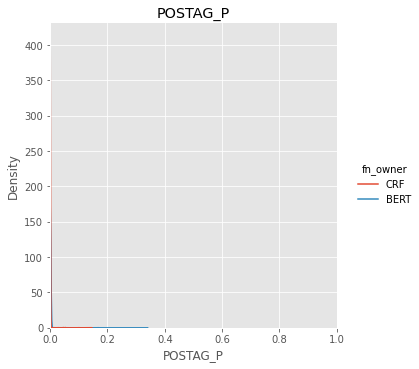

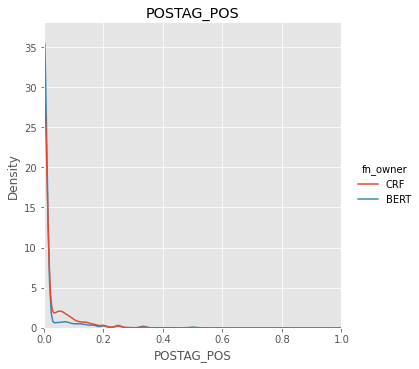

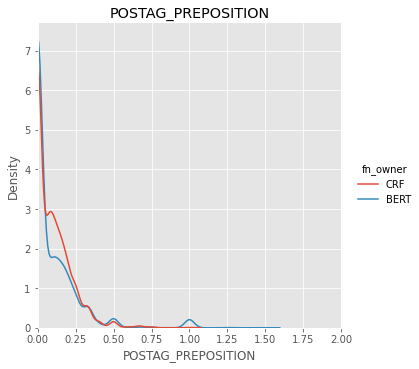

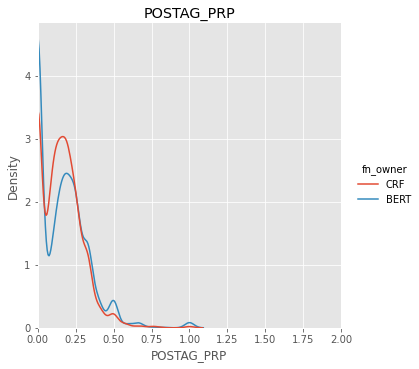

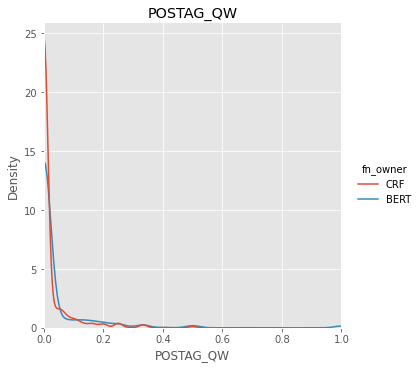

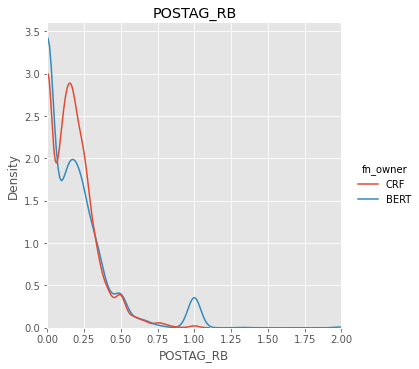

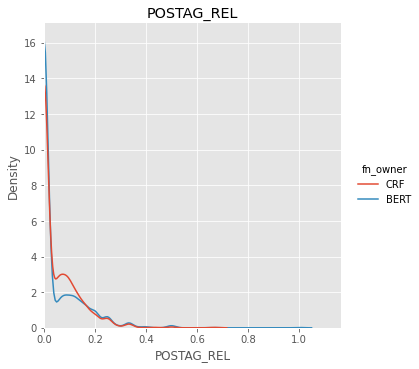

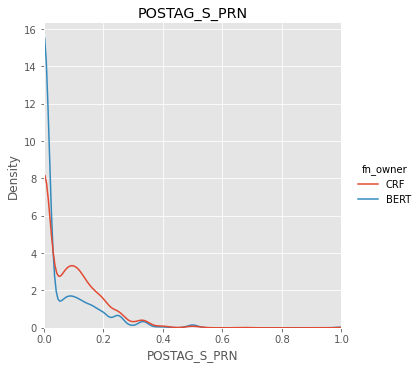

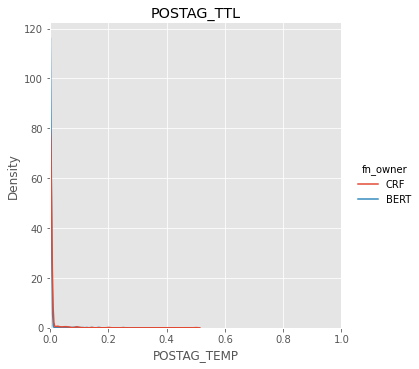

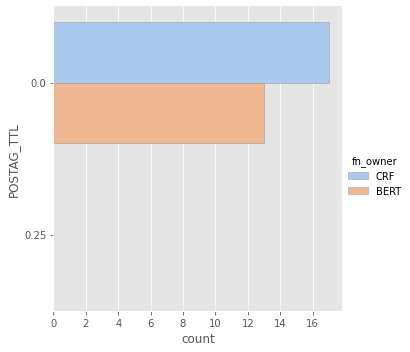

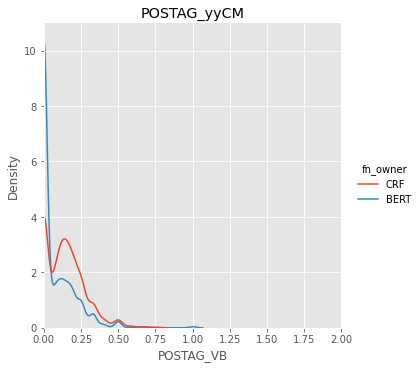

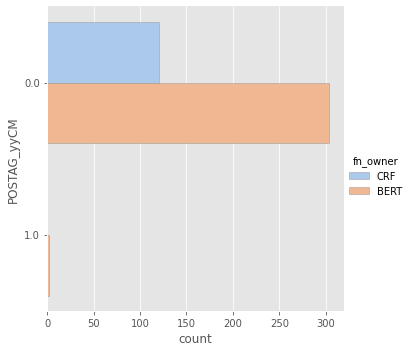

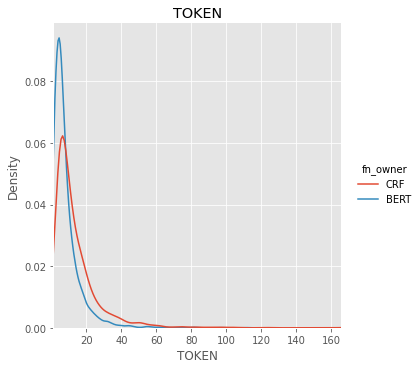

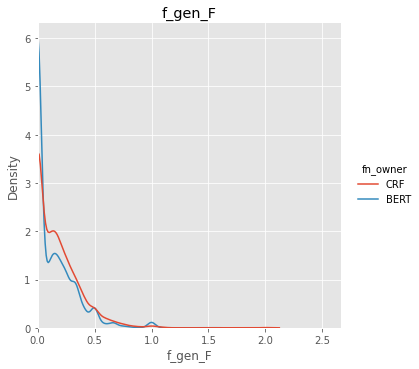

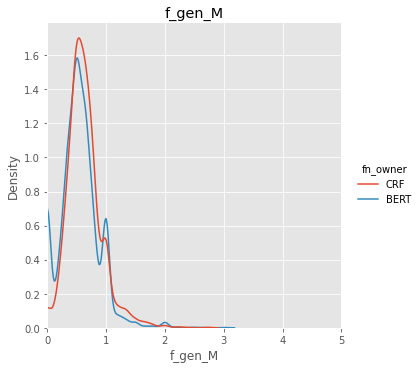

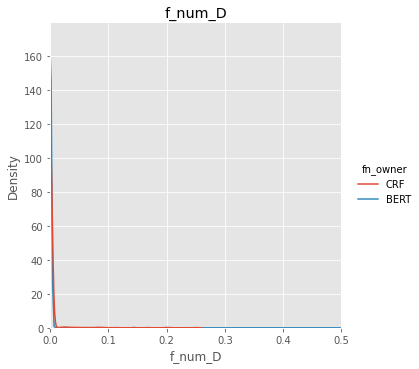

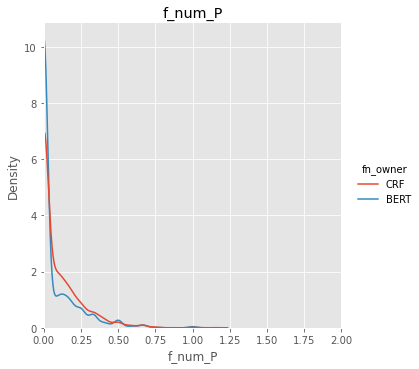

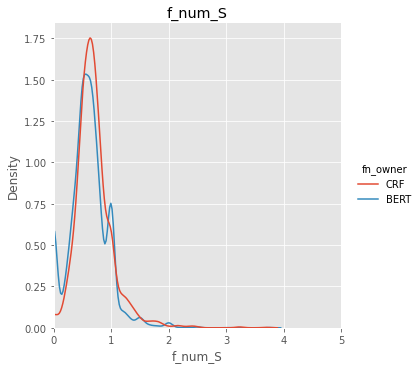

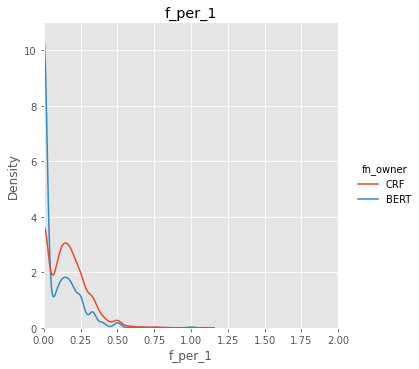

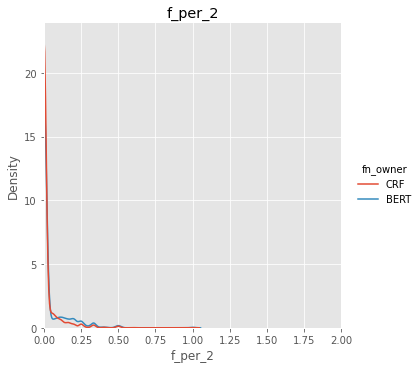

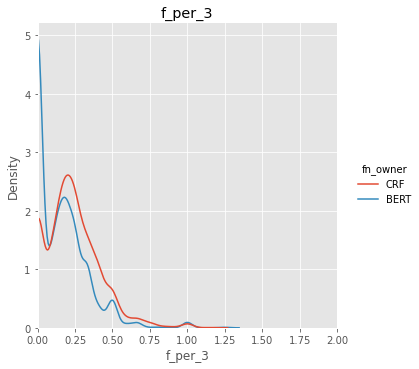

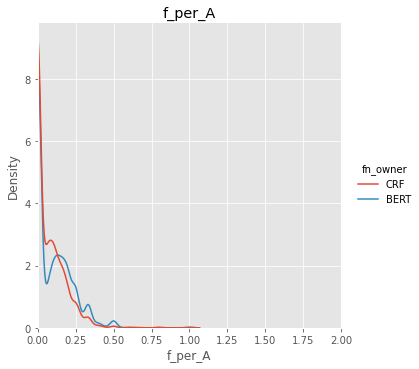

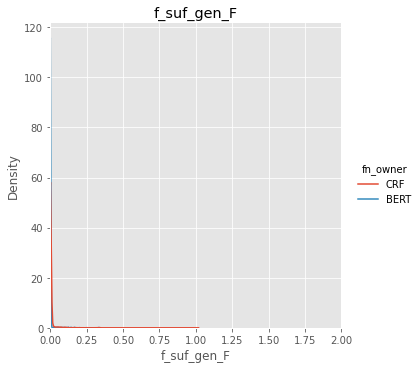

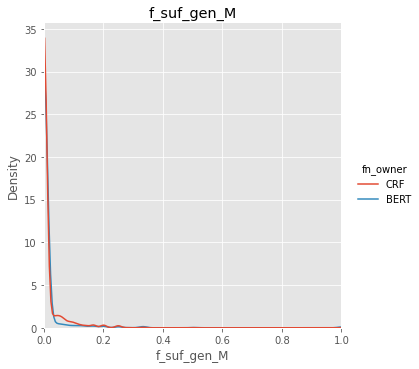

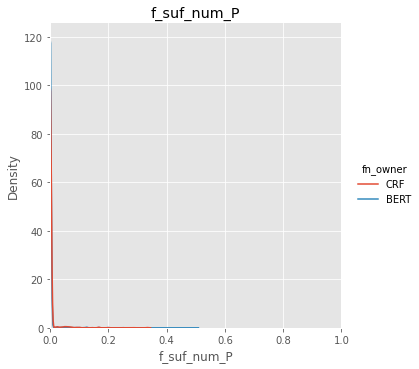

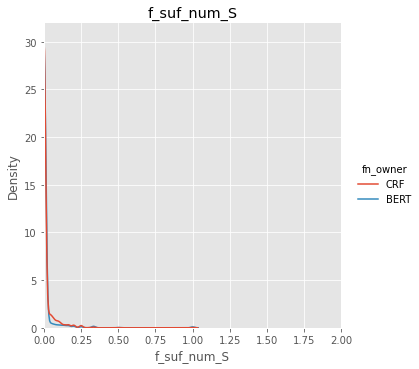

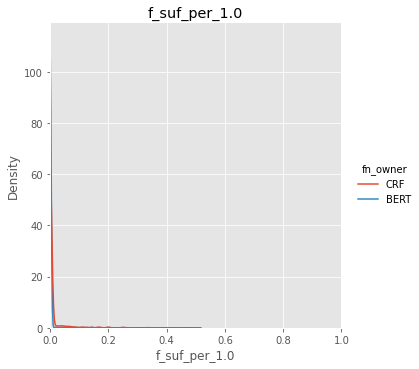

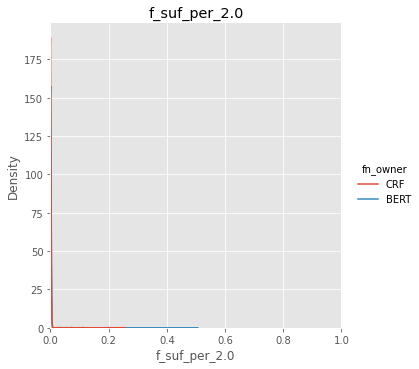

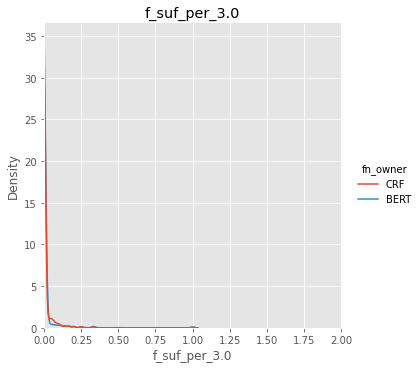

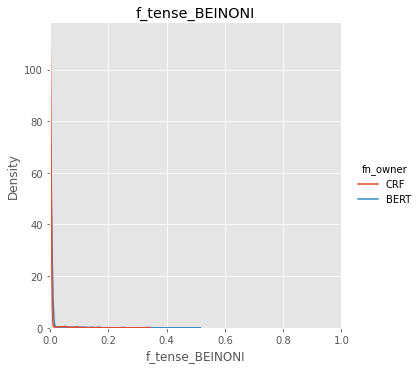

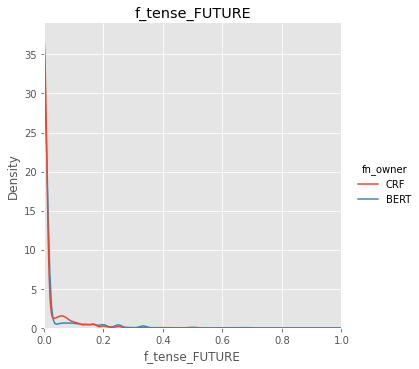

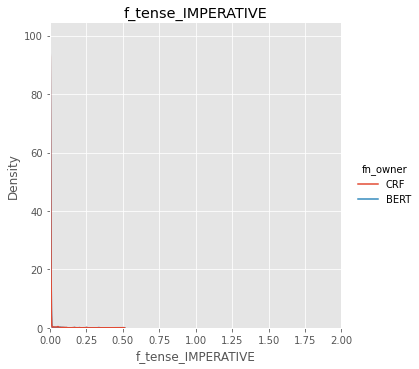

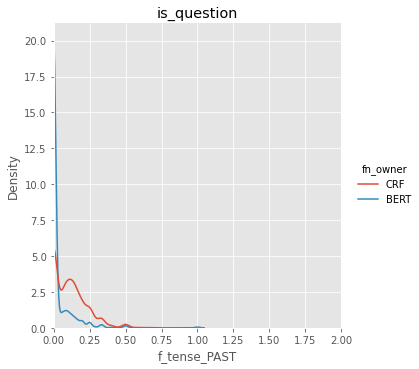

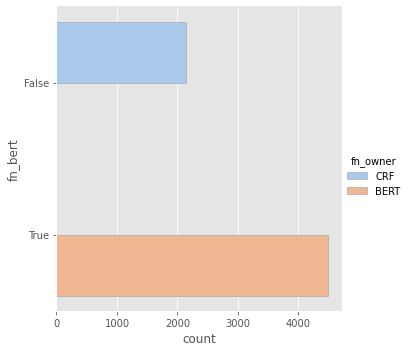

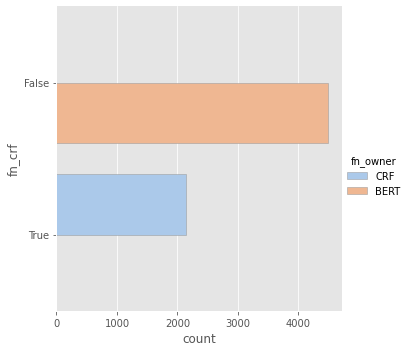

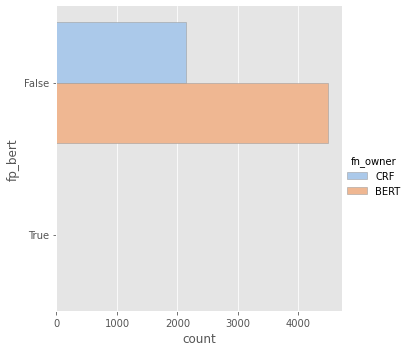

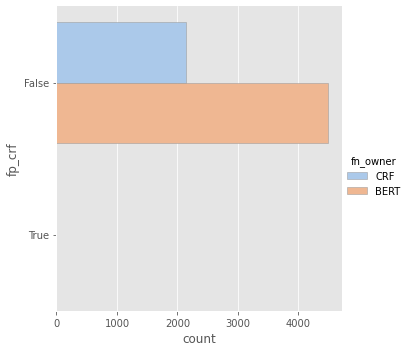

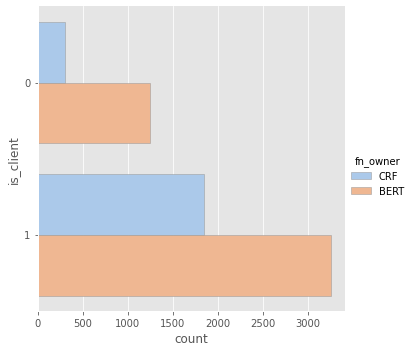

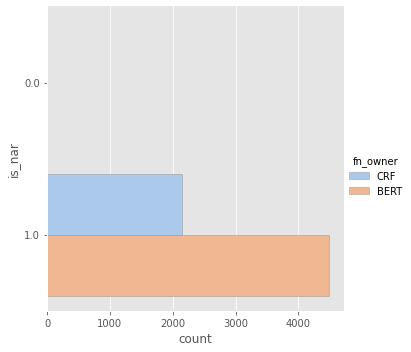

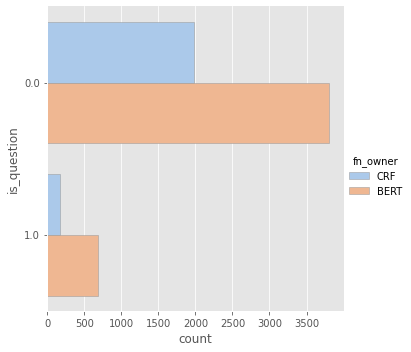

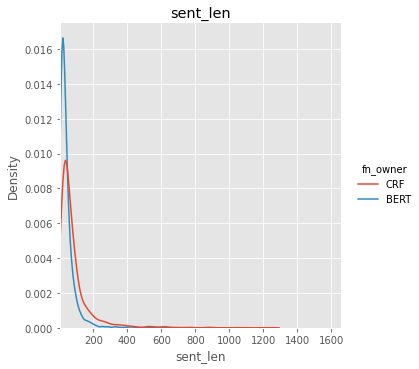

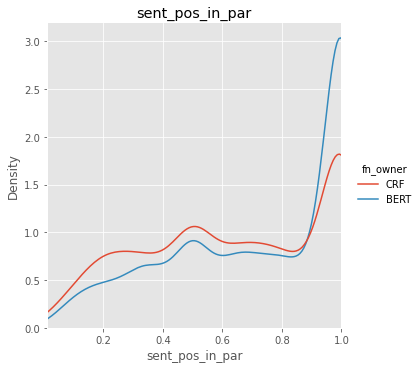

In [221]:
for col in plot_cols:
# col='POSTAG_TTL'
    if fp_fn_error_db[col].nunique()<3:
        type_plot='bar'
#         sns_plot =  sns.barplot(data=fp_fn_error_db,
#                             x=col,
#                             hue='fn_owner',
#                           )
#         sns_plot =  sns.catplot(data=fp_fn_error_db,
#                     x=col,
#                     hue='fn_owner',
#                    )
        sns.catplot(
            data=fp_fn_error_db, y=col, hue="fn_owner", kind="count",
            palette="pastel", edgecolor=".6",
        )
    else:
        type_plot='kde'
        sns_plot =  sns.displot(data=fp_fn_error_db,
                                    x=col,
                                    kind=type_plot,
                                    hue='fn_owner',
                                    common_norm=False
                                   )
        sns_plot.set(xlim=(fp_fn_error_db[col].min(),fp_fn_error_db[col].max()))
    sns_plot.set(title=col)

/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/zsofya/jupyter_git/jup-nb-generic/lib/python3.8/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


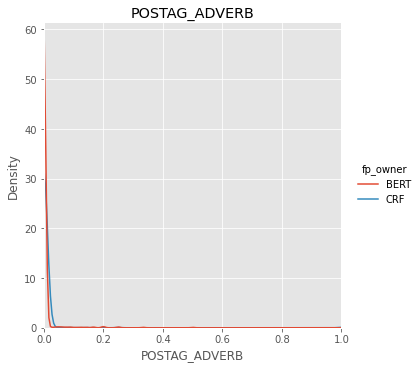

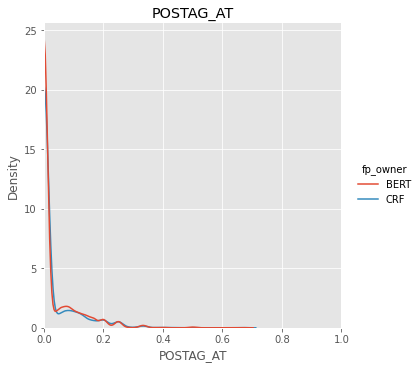

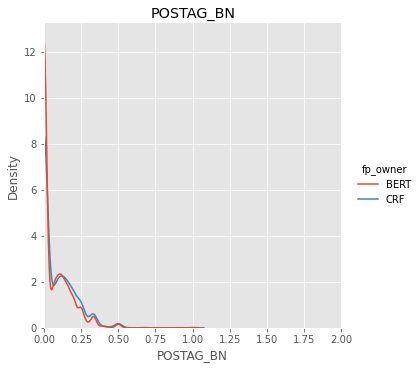

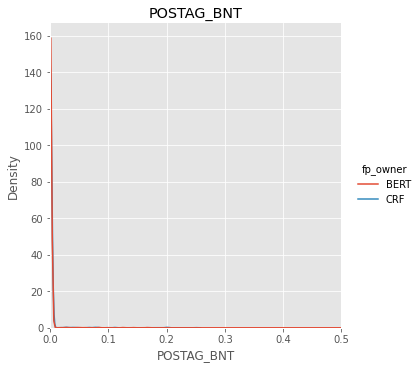

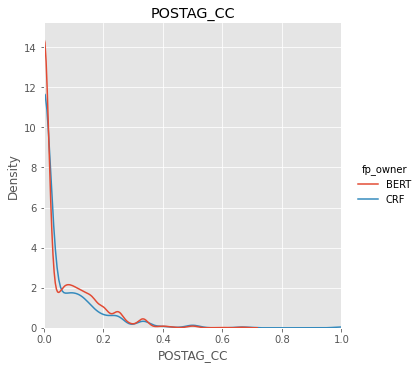

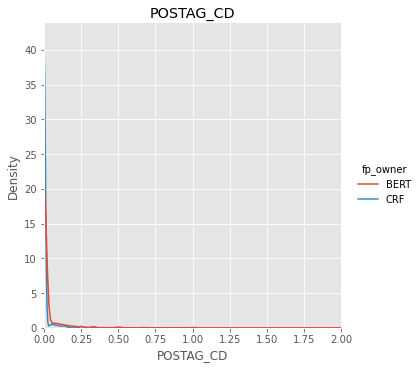

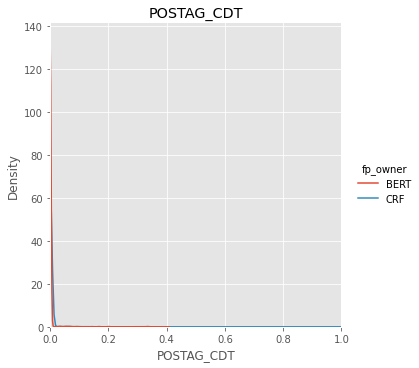

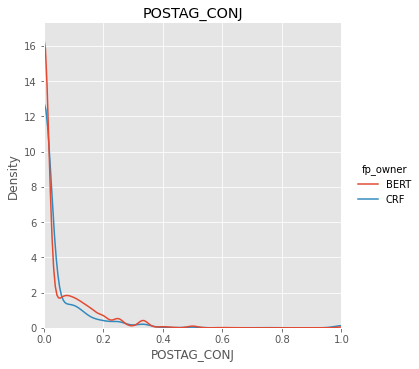

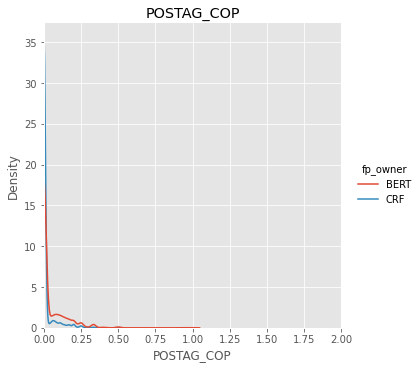

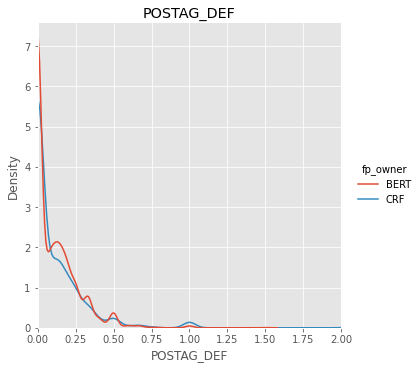

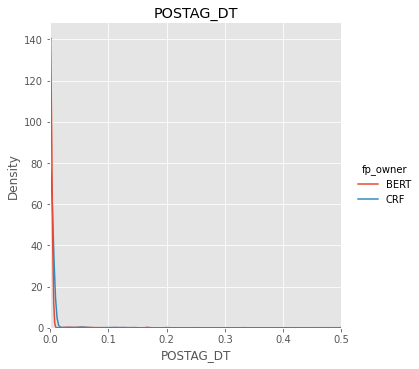

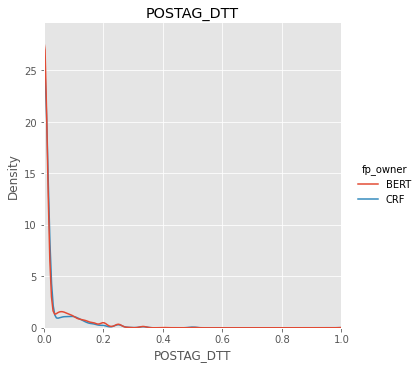

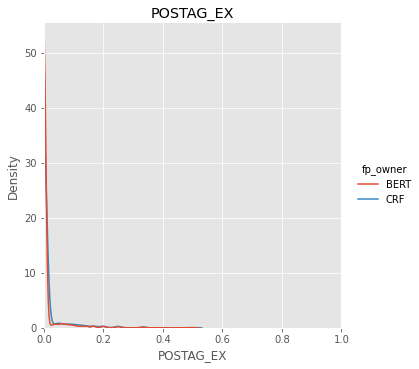

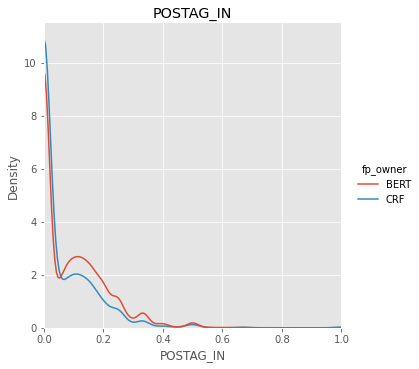

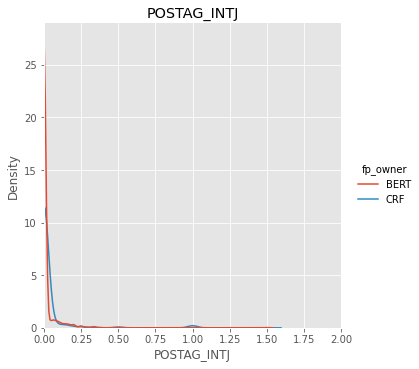

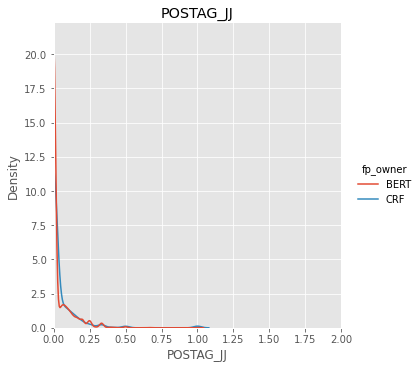

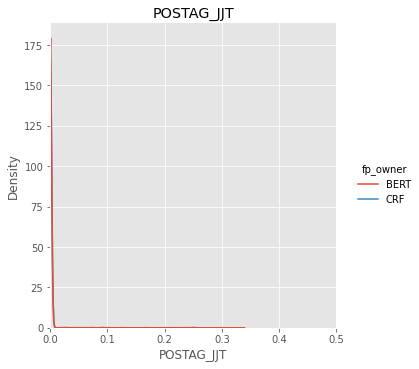

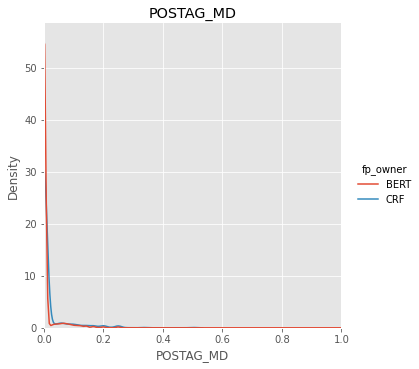

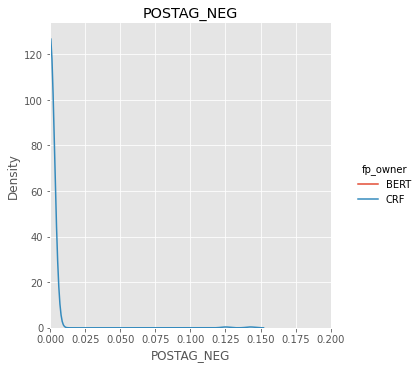

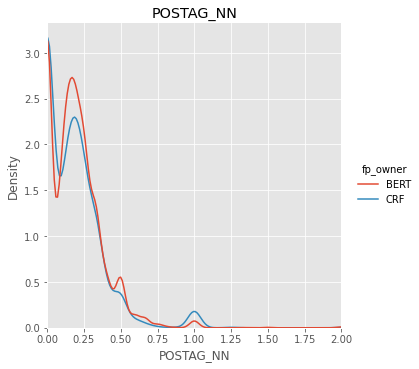

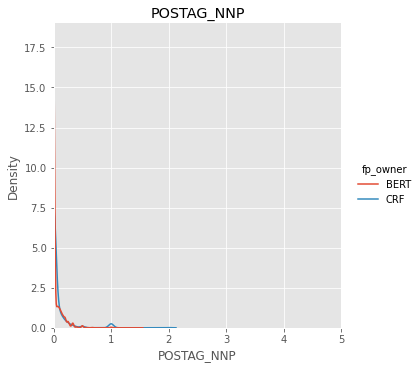

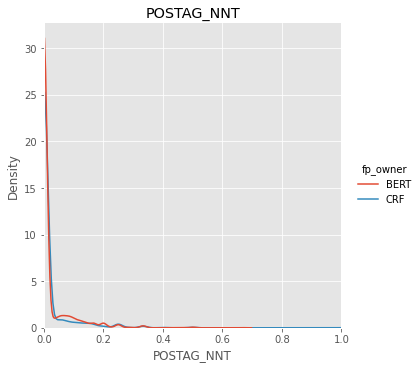

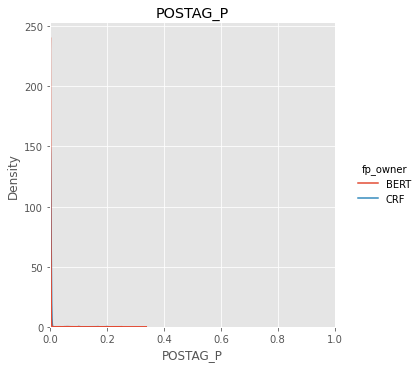

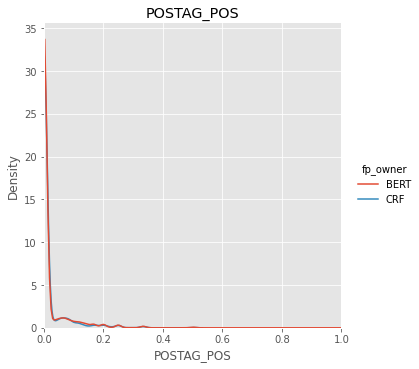

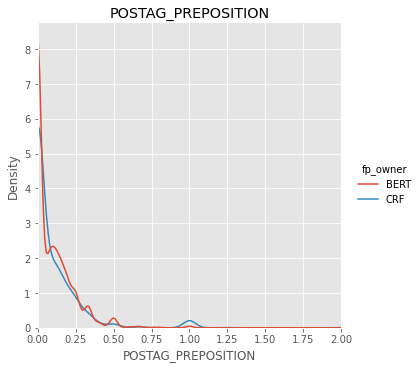

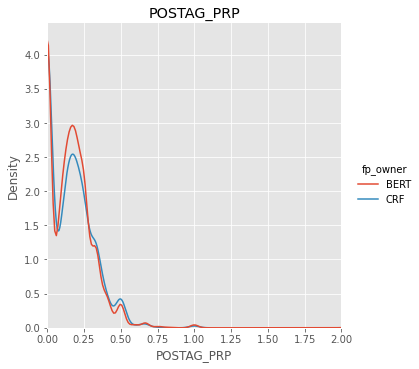

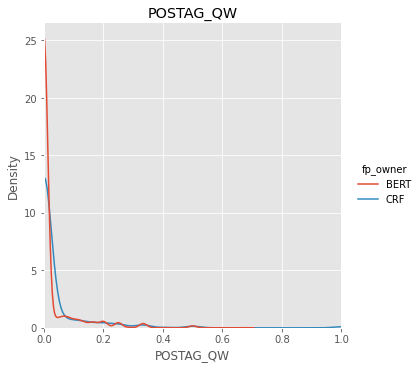

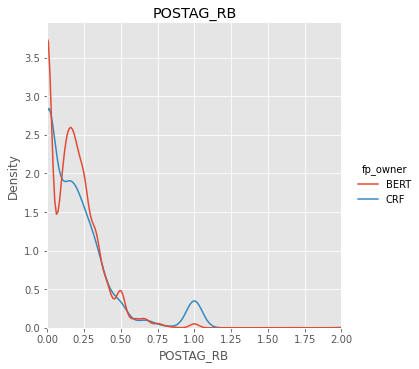

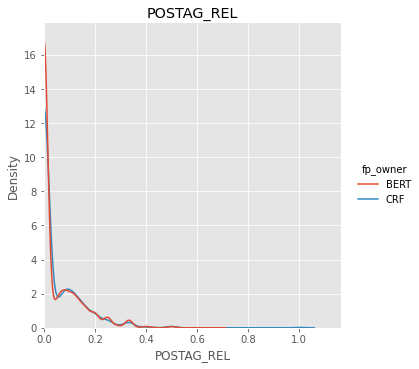

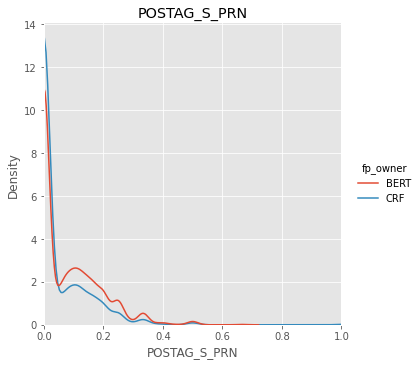

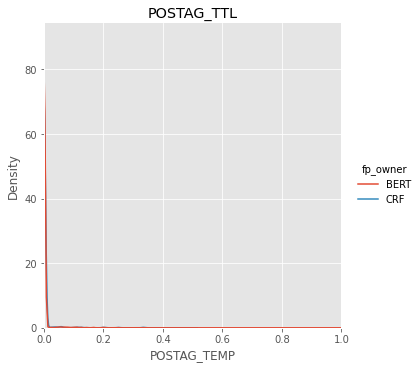

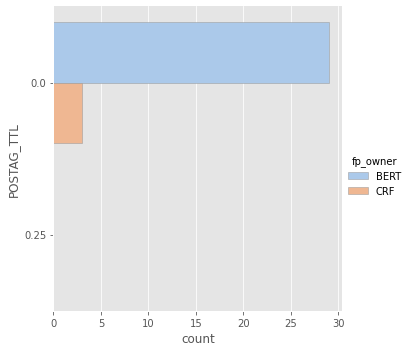

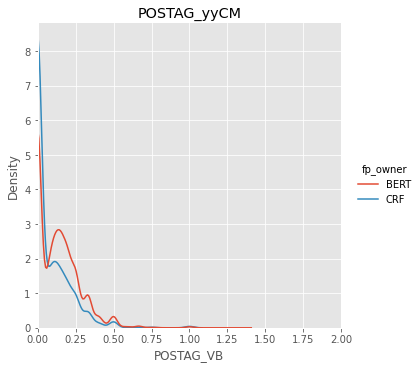

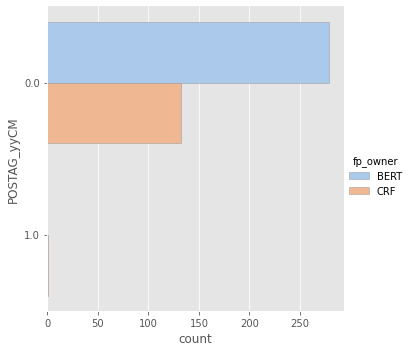

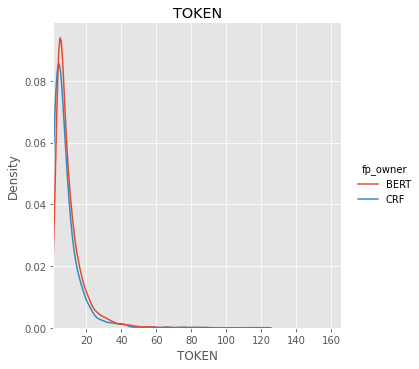

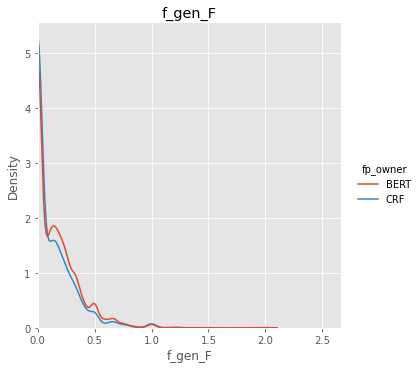

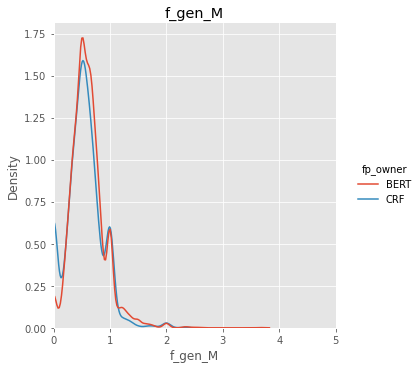

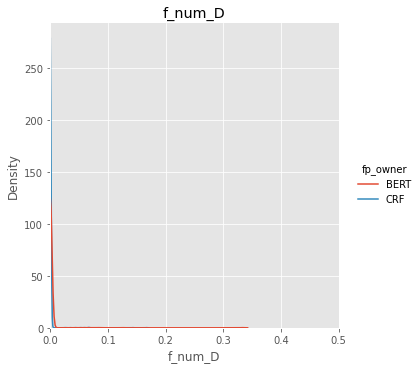

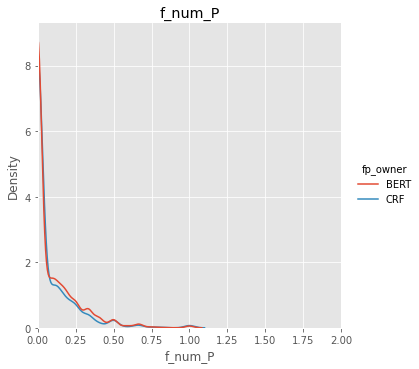

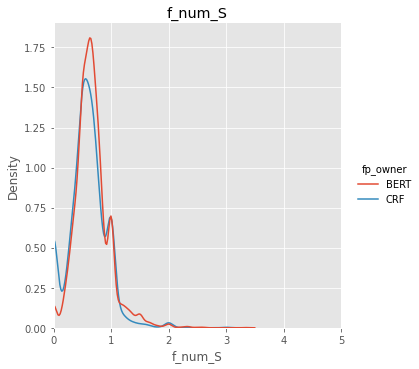

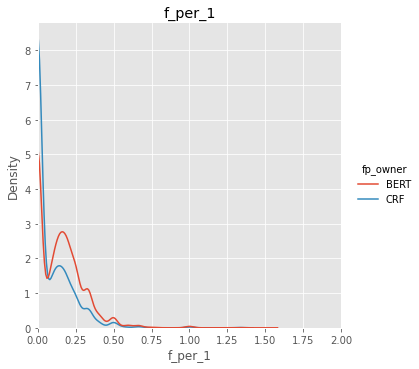

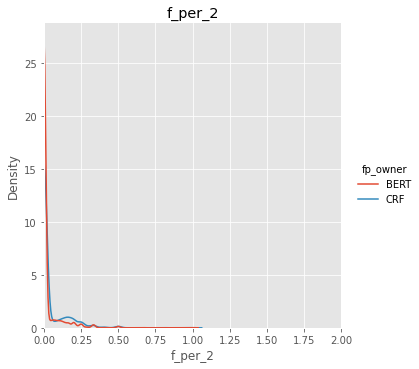

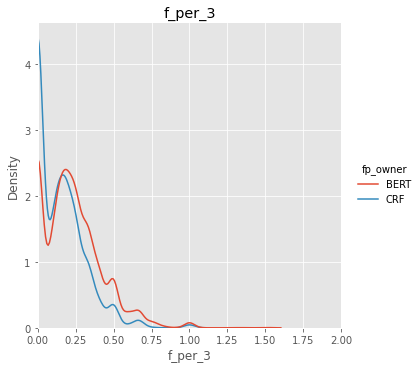

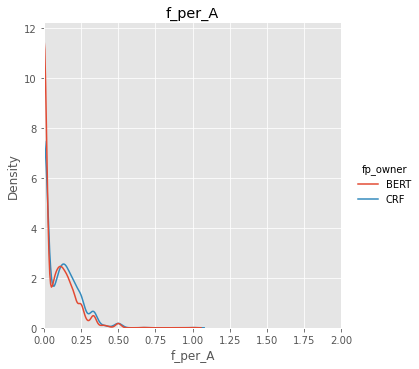

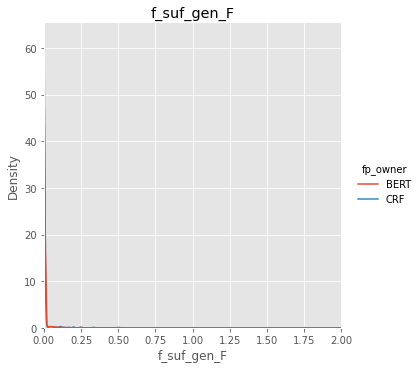

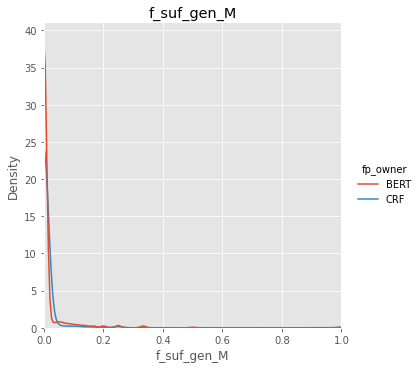

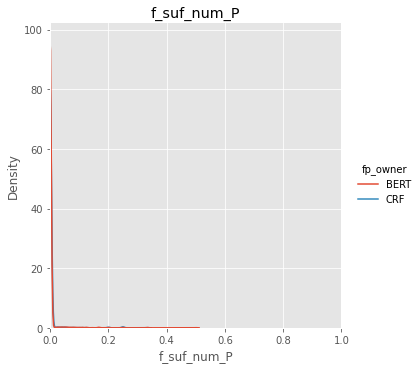

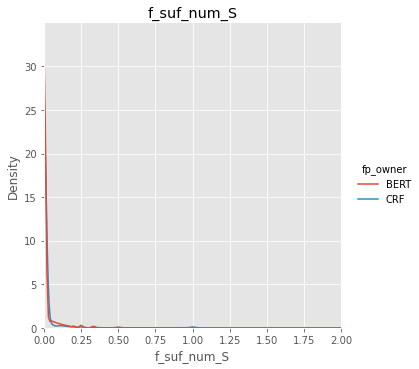

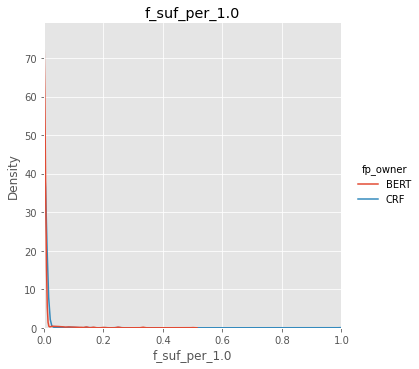

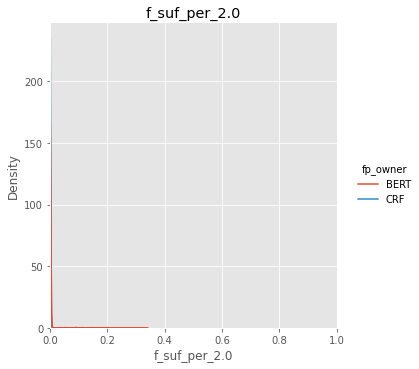

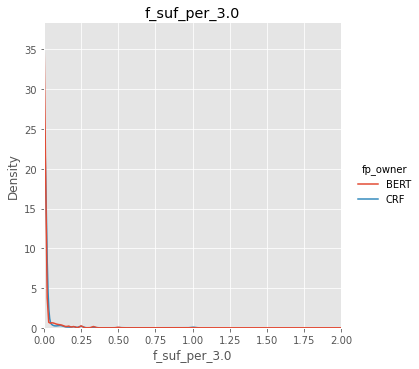

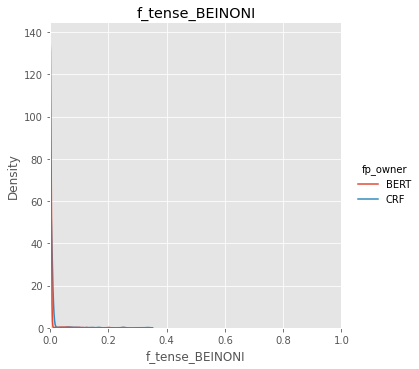

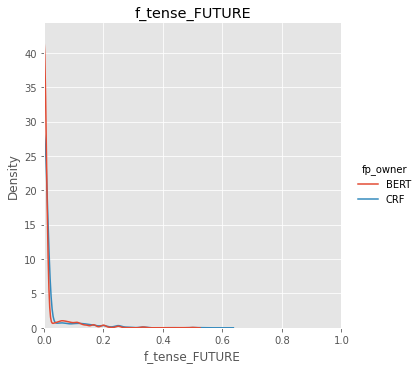

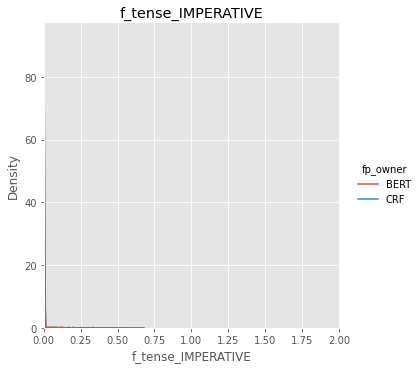

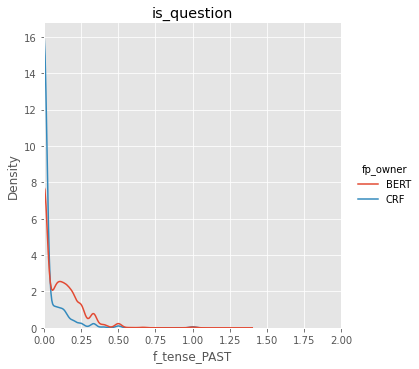

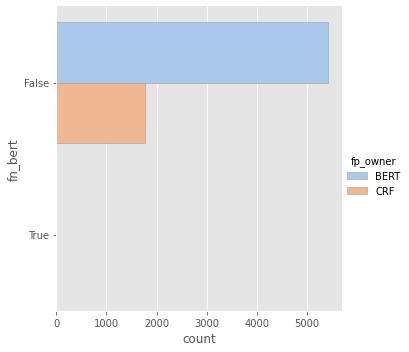

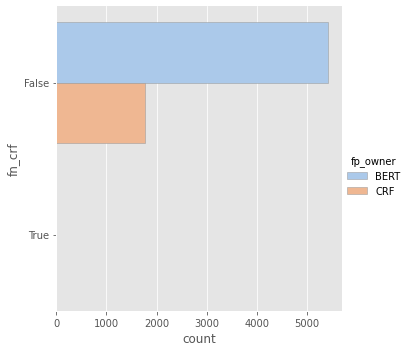

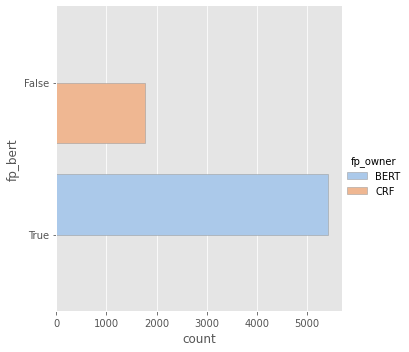

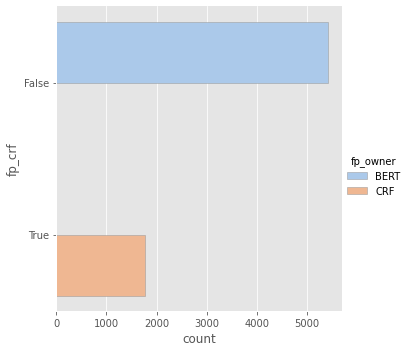

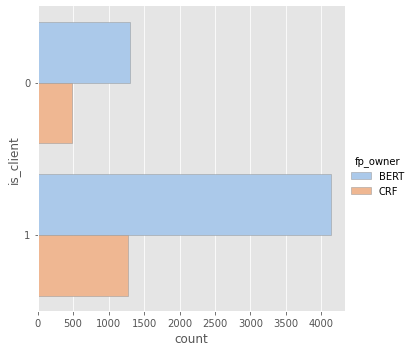

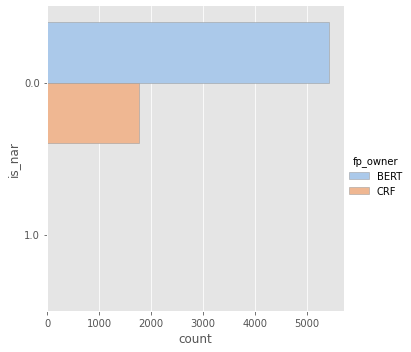

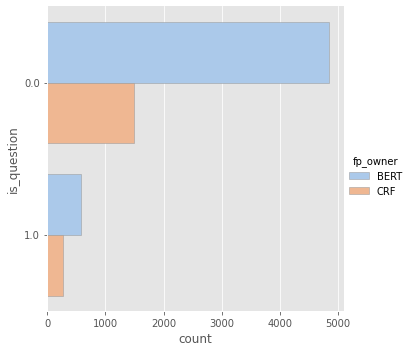

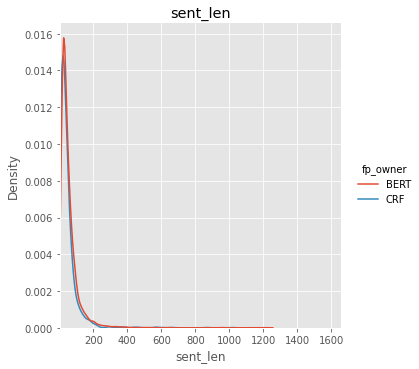

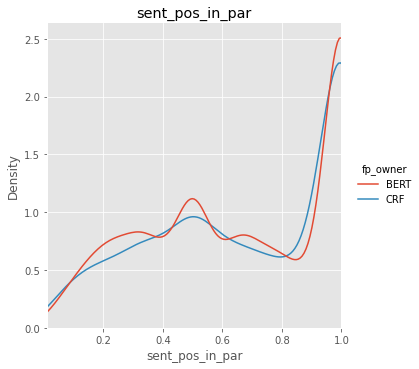

In [222]:
for col in plot_cols:
# col='POSTAG_TTL'
    if fp_fn_error_db[col].nunique()<3:
        type_plot='bar'
#         sns_plot =  sns.barplot(data=fp_fn_error_db,
#                             x=col,
#                             hue='fn_owner',
#                           )
#         sns_plot =  sns.catplot(data=fp_fn_error_db,
#                     x=col,
#                     hue='fn_owner',
#                    )
        sns.catplot(
            data=fp_fn_error_db, y=col, hue="fp_owner", kind="count",
            palette="pastel", edgecolor=".6",
        )
    else:
        type_plot='kde'
        sns_plot =  sns.displot(data=fp_fn_error_db,
                                    x=col,
                                    kind=type_plot,
                                    hue='fp_owner',
                                    common_norm=False
                                   )
        sns_plot.set(xlim=(fp_fn_error_db[col].min(),fp_fn_error_db[col].max()))
    sns_plot.set(title=col)